## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

In [1]:
# Common imports
import os
import sys
import pandas as pd
import numpy as np
import json
import time
import datetime as dt
from PIL import Image
from collections import Counter, defaultdict

# Ploting
import matplotlib.pyplot as plt

# Evaluation 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

# Experiment
from joblib import Parallel, delayed
import traceback

# Notebook variables
seed = 0
# np.random.seed(seed)
# rng = np.random.default_rng(seed)

# Folder locations of datasets
orl_data_location = 'data/ORL'
yaleB_data_location = 'data/CroppedYaleB'

# Log file
log_file = 'experiment_results.txt'

if os.path.exists(log_file):
    os.remove(log_file)
    print("Previous Log File deleted.")
else:
    print("Previous Log File does not exist.")

Previous Log File deleted.


In [2]:

# Experiment variables
# Common
datasets = ["ORL", "YALE"]
methods  = ["Frobenius", "L21"]
noise_types = ['salt_pepper', 'block']
normalization = ["none", "per_image", "global"]

# base hyperparameter grid
base = {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image", # "none" or "per_image" or "global"
    "noise_type": "salt_pepper",  # type of adding noise
    "noise_p": 0.05,
    "noise_r": 0.5,
    "nmf_type": "Frobenius",      # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 1000,
    "tol": 1e-4,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12,
}

# Salt and Pepper noise variables
# (p, r) values where p is the ratio of pixels modified and r is the ratio of modified pixels being white (otherwise black)
sp_noise_combos = [
    (0.01, 0.5), 
    (0.05, 0.3), 
    (0.1, 0.5),   
    (0.1, 0.7),  
    (0.2, 0.5),   
    (0.3, 0.3),  
    (0.3, 0.7),   
]

# Block noise variables
block_noise_ratio = [0.1, 0.2, 0.3, 0.4] # values are the ratio of the side length of the noise square to the image's width
num_blocks = [1,2,3] # sets the number of noise squares to be generated

## 1. Load Dataset

### 1.0 Data Folder

In [3]:
# Path to your dataset zip stored in Drive
zip_path = "data.zip"

# Unzip file
!unzip -o -q "$zip_path" 

In [4]:
# The structure of data folder.
!ls -l data

total 0
drwxrwxrwx@ 41 jamie.saunders  staff  1312 Oct  9 21:35 CroppedYaleB
drwx------@ 44 jamie.saunders  staff  1408 Oct  9 21:35 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [5]:
def load_data(root, reduce=2, normalization="per_image", eps=1e-12):
    """
    Load ORL or Extended YaleB dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        normalisation: context for which to apply normalisation
        epis: epsilon value to prevent division by zeo / stabilize the computation
    """

    # Initialise variables
    images, labels = [], []
    height, width = 0, 0

    for i, person in enumerate(sorted(os.listdir(root))):  # Loop through files in the root path

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):
            
            if fname.endswith('Ambient.pgm'): # Remove background images in Extended YaleB dataset.
                continue

            if not fname.endswith('.pgm'):
                continue

            img = Image.open(os.path.join(root, person, fname)) # load image.
            img = img.convert('L') # grey image.

            img = img.resize([s//reduce for s in img.size]) # reduce computation complexity.

            if (height == 0 or width == 0): # save the height/width after resizing
              height = img.size[1]
              width = img.size[0]

            img = np.asarray(img, dtype=np.float32) # convert img to array

            if normalization == "per_image":  # normalzation per image
              img = (img - img.min()) / (img.max() - img.min() + eps)

            img = img.reshape((-1,1)) # reshape image array

            images.append(img)  # collect data and label.
            labels.append(i)

    images = np.concatenate(images, axis=1) # concate all images and labels.
    labels = np.array(labels)

    if normalization == "global": # normalize globally
      images = images.astype(np.float32)
      images = images / 255.0 # normalizing them

    # return the images array (V) labels (Y) and the dimensions of the new images (height and width)
    return images, labels, height, width

In [6]:
# randomly select 90%
def make_stratified_subset(V, Y, V_hat, frac=0.9, seed=0):
  """
  Creates a stratified subset

  Args:
    V: Noisy matrix
    Y: Target labels
    V_hat: Clean matrix
    frac: ratio of total examples selected for the subset
    seed: for RNG replication
  """
  
  rng = np.random.default_rng(seed)
  labels = np.unique(Y)
  idx_trimmed = []
  for cls in labels:
    cls_idx = np.where(Y == cls)[0]
    amount_to_keep = int(frac * len(cls_idx))
    chosen = rng.choice(cls_idx, size=amount_to_keep, replace=False)
    idx_trimmed.extend(chosen)
  idx_trimmed = np.array(idx_trimmed)
  V_trimmed = V[:, idx_trimmed]
  Y_trimmed = Y[idx_trimmed]
  V_hat_trimmed = V_hat[:, idx_trimmed]
  return V_trimmed, Y_trimmed, V_hat_trimmed

### 1.2 Generate and Apply Noise to Dataset
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [9]:
# salt and pepper noise
def add_sp_noise(V_hat, p=0, r=0, seed=0):
  """
  Apply salt and pepper noise to an image dataset.

  Args:
    V_hat: Clean matrix, used to form shape of V_noise
    p: hyperparameter to control the noise leve
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    rng: for RNG functions
  """
  rng = np.random.default_rng(seed)

  m, n = V_hat.shape # n images, each has m pixels in a flat vector

  V_noise = V_hat.copy()

  for i in range(n): #iterate through each image
    for j in range(m): #iterate through each pixel
      if rng.random() < p: #we modify the pixel
        if rng.random() < r:
          V_noise[j, i] = 1.0 # turn the pixel white
        else:
          V_noise[j, i] = 0.0 # turn the pixel black

  return V_noise


# block occlusion noise
def add_block_noise(V_hat, h, w, ratio=None, num_blocks=None, log_return=False, seed=0):
  """
  Apply block occlusion noise to an image dataset.

  Args:
    V_hat: dataset to create a copy of with noise applied
    r: hyperparameter to control the ratio of white (salt) and black (pepper) pixels
    log_return: boolean to drive the returning of logging details
  """
  m, n = V_hat.shape # n images, each has m pixels in a flat vector
  V_noise = V_hat.copy()
  min_square_size = m
  max_square_size = 0
  noise_log = []
  i = 0
  ii = 0

  rng = np.random.default_rng(seed)

  if log_return:
    print(f"Dimenstions (V_hat m): {m}")
    print(f"Images (V_hat n): {n}")
    print(f"Image width: {w}")
    print(f"Image height: {h}")

  for img in range(n): # Iterate through each image
    blocks = 0
    if ratio is None:
      print('ratio none')
      total_ratio = rng.uniform(.1, .4) * w
    else:
      total_ratio = ratio * w
      
    if num_blocks is None:
      num_blocks = rng.integers(1, 4)

    # Generates square sizes using RNG whilst keeping satisfying the total ratio value  
    square_sizes = rng.dirichlet(np.ones(int(num_blocks))) * total_ratio
    
    for sq in square_sizes:  
      # Random top-left corner, making sure the square fits in the image
      x = rng.integers(0, w - sq)
      y = rng.integers(0, h - sq)

      j = x + y * w 
      noise_log.append({"img":img, "start_index":j, "start_point":f"({x},{y})", "square_size":round(sq,2)})
      # Set the square to white (255)
      while i < sq:
        while ii < sq: # Iterates through pixels row by row along the square region
          V_noise[j+ii][img] = 1
          ii = ii + 1
        i = i + 1
        ii = 0
        j = (i + y) * w + x
      i = 0 # Resets for the next block
      ii = 0
      blocks = blocks + 1
      min_square_size = min(min_square_size, sq)
      max_square_size = max(max_square_size, sq)
    
  if log_return:
    print(f"min square size: {min_square_size}")
    print(f"max square size: {max_square_size}")
    print(json.dumps(noise_log, indent=4))

  return V_noise, noise_log

### 1.3 Noise Demonstration
Display a random sample of the original images alongside the images post noise generation for each dataset

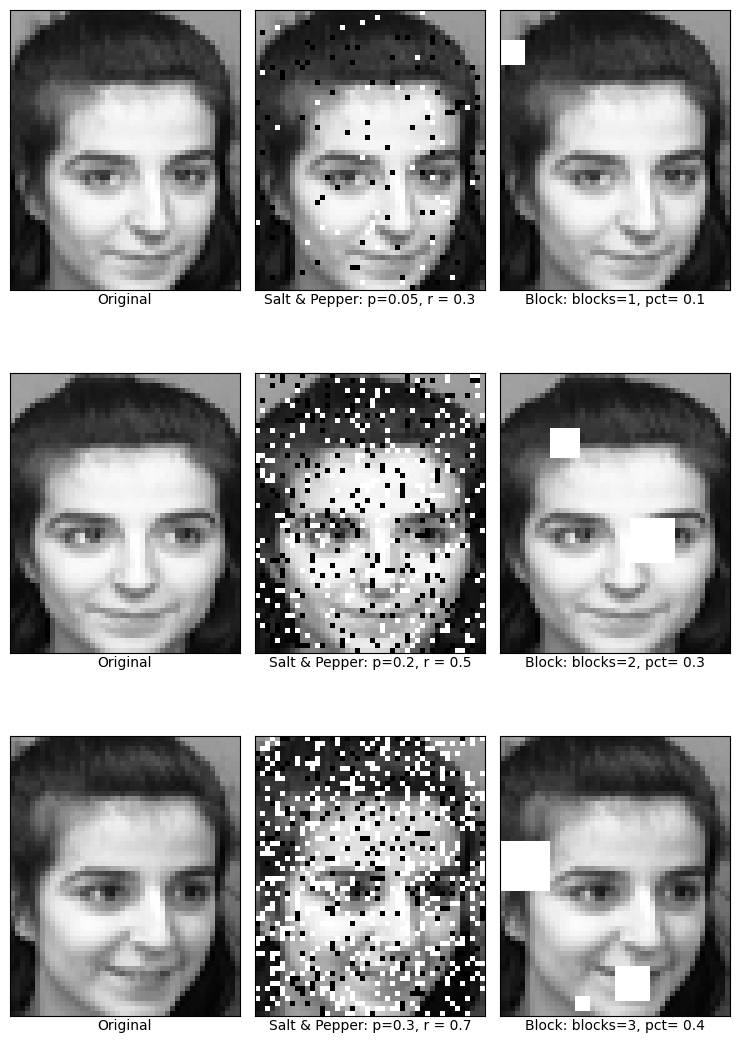

In [13]:
# How many images to display and plot structure
num_imgs = 3
rows, cols = num_imgs, 3   # Original + two noise types
fig, axes = plt.subplots(rows, cols, figsize=(7.5, 12))

# block noise config for demo (reduced set)
block_noise_combos_demo = [
    (0.1, 1), 
#    (0.2, 2), 
    (0.3, 2), 
    (0.4, 3)
]

# S&P noise config for demo (reduced set)
sp_noise_combos_demo = [
    (0.05, 0.3), 
#    (0.1, 0.7),  
    (0.2, 0.5),   
    (0.3, 0.7),   
]

# Loading original data
V_hat, Y_hat, h, w = load_data(root=orl_data_location, normalization='per_image')

# Defining start index to output (which image)
start_ind = 10 #np.random.randint(0, len(V_hat[0])-num_imgs)
end_ind = start_ind + num_imgs 

# Looping over each index (image) and displaying the original next to 2 with noise applied
for i, ind in enumerate(range(start_ind, end_ind)):
    
    # Original  Image
    ax = axes[i, 0]
    ax.imshow(V_hat[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel('Original', labelpad=2)

    ax = axes[i, 1]
    # Salt & Pepper noise
    v_noise_sp = add_sp_noise(V_hat, sp_noise_combos_demo[i][0], sp_noise_combos_demo[i][1])
    ax.imshow(v_noise_sp[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel(f'Salt & Pepper: p={sp_noise_combos_demo[i][0]}, r = {sp_noise_combos_demo[i][1]}', labelpad=2)

    ax = axes[i, 2]
    # Block noise
    v_noise_block, noise_log = add_block_noise(V_hat, h, w, block_noise_combos_demo[i][0], block_noise_combos_demo[i][1], seed=0)
    ax.imshow(v_noise_block[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel(f"Block: blocks={block_noise_combos_demo[i][1]}, pct= {block_noise_combos_demo[i][0]}", labelpad=2)
    
    # Remove ticks for a clean layout
    for j in range(cols):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Reduce gaps between subplots
plt.subplots_adjust(
    wspace=0.05,   # horizontal space
    hspace=0.15    # vertical space
)

# Displaying the plot
#fig.suptitle(f"Noise Type Comparison: {datasets[0]}", fontsize=14, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"img/orl_noise_demonstration.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# How many images to display and plot structure
num_imgs = 3
rows, cols = num_imgs, 3   # Original + two noise types
fig, axes = plt.subplots(rows, cols, figsize=(7.5, 12))

# Loading original data
V_hat, Y_hat, h, w = load_data(root=yaleB_data_location, normalization='per_image')

# Defining start index to output (which image)
start_ind = 10 #np.random.randint(0, len(V_hat[0])-num_imgs)
end_ind = start_ind + num_imgs 

# Looping over each index (image) and displaying the original next to 2 with noise applied
for i, ind in enumerate(range(start_ind, end_ind)):
    
    # Original  Image
    ax = axes[i, 0]
    ax.imshow(V_hat[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel('Original', labelpad=2)

    ax = axes[i, 1]
    # Salt & Pepper noise
    v_noise_sp = add_sp_noise(V_hat, sp_noise_combos_demo[i][0], sp_noise_combos_demo[i][1])
    ax.imshow(v_noise_sp[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel(f'Salt & Pepper: p={sp_noise_combos_demo[i][0]}, r = {sp_noise_combos_demo[i][1]}', labelpad=2)

    ax = axes[i, 2]
    # Block noise
    v_noise_block, noise_log = add_block_noise(V_hat, h, w, block_noise_combos_demo[i][0], block_noise_combos_demo[i][1], seed=0)
    ax.imshow(v_noise_block[:, ind].reshape(h, w), cmap=plt.cm.gray)
    ax.set_xlabel(f"Block: blocks={block_noise_combos_demo[i][1]}, pct= {block_noise_combos_demo[i][0]}", labelpad=2)
    
    # Remove ticks for a clean layout
    for j in range(cols):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Reduce gaps between subplots
plt.subplots_adjust(
    wspace=0.05,   # horizontal space
    hspace=0.15    # vertical space
)

# Displaying the plot
#fig.suptitle(f"Noise Type Comparison: {datasets[1]}", fontsize=14, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"img/yale_noise_demonstration.png", dpi=300, bbox_inches='tight')
plt.show()

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [362]:
# Defining NMF Funtions

# FSE method
def frobenius_squared_error(V, W, H):
  """
  Return frobenious squared reconstruction error

  Args:
    V: Noisy matrix
    W: Basis matrix
    H: Encoding matrix
  """

  WH = W @ H  # Matrix multiplication of W and H
  return np.sum((V - WH) ** 2)  # Returning fse

def rre_fse(V_hat, W, H, eps=1e-12): 
  """
  Return relative reconstruction frobenious error

  Args:
    V_hat: Clean data matrix (no-noise)
    W: Basis matrix
    H: Encoding matrix
    eps: epsilon value to prevent division by zeo / stabilize the computation
  """

  WH = W @ H   # Matrix multiplication of W and H
  FE = np.linalg.norm( V_hat - WH, ord='fro') # Calculating numerator value from fse error
  denom = np.linalg.norm(V_hat, ord='fro')  # Calculating denominator value
  RRE = FE / (denom + eps)  # RRE calculation
  return RRE

def l21_norm(V, W, H): # finds the L_2,1 Norm objective function result
    """
    Return L21 norm reconstruction error

    Args:
      V: Data matrix
      W: Basis matrix
      H: Encoding matrix
    """
    
    R = V - W @ H   # Calculating residuals
    return np.linalg.norm(R, axis=0).sum(0) #Returning l21 norm, axis =0 means we go column by column

def rre_l21_norm(V, W, H, eps=1e-12):
  """
  Computes u the vector instead of matrix U. Faster calculations

  Args:
    V: Data matrix
    W: Basis matrix
    H: Encoding matrix
    eps: epsilon value to prevent division by zeo / stabilize the computation
  """
  R = V - W @ H # Calculating residuals
  nom = np.linalg.norm(R, axis=0).sum(0)  # Calculating numerator value from l21 error
  denom = np.linalg.norm(V, axis=0).sum(0)  # Calculating denominator value
  RRE = nom / (denom + eps) # RRE calculation
  return RRE

def compute_u(V, WH, eps=1e-12):
    """
    Computes u the vector instead of matrix U. Faster calculations

    Args:
      V: Data matrix
      WH: matrix product of W and H
      eps: epsilon value to prevent division by zeo / stabilize the computation
    """

    R = V - WH  # Calculating residuals
    col_norms = np.linalg.norm(R, axis=0) # gets a vector of all the norms of the columns of R
    u = 1.0 / np.maximum(col_norms, eps) # inverts them
    return u

In [363]:
def log_experiment(df, experiment_name, filename=log_file):
  """
  Record the experimental result
  """
  mode = "a" if os.path.exists(filename) else "w"
  with open(filename, mode) as f:
      if mode == "w":  # first record
          f.write("===== Experiment Log Start ======================================\n\n")
      f.write(f"===== {dt.datetime.now()} == New Experiment: {experiment_name} =====\n")
      f.write(df.to_string(index=False))
      f.write("\n\n")

In [364]:
def assign_cluster_label(X, Y, verbosity=1):
  """
  Assigns the KMeans clusters to the ground-truth class labels by majority vote

  Args:
    X: Feature matrix to cluster
    Y: Groud-truth class labels
    verbosity: Higher value has more debug print statements generated
  """
  if verbosity >= 2:
    print("Num of classes = ", len(set(Y)))
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

In [365]:
def fse_mur(V, W, H, max_iterations, tol, eps=1e-12, verbosity=1):
  """
  Multiplicative update rules using frobenious squared error

  Args:
    V: Data matrix
    W: Basis matrix
    H: Encoding matrix
    max_iterations: Setting the upper limit of iterations run
    tol: Value for early stopping checks
    eps: epsilon value to prevent division by zeo / stabilize the computation
  """

  if verbosity >= 1:
    print("Starting FSE MUR training...")
  errors = []
  prev = None

  iterations_done = 0

  for it in range(max_iterations):
      # Calculates numerator and denominator for H update step
      numerator_H = W.T @ V
      denominator_H = (W.T @ W @ H)

      H = H * numerator_H / (denominator_H + eps) # updates H

      # calculates num and denom using updated H matrix
      numerator_W = V @ H.T
      denominator_W = (W @ H @ H.T)

      W = W * numerator_W / (denominator_W + eps) # updates W

      training_error = frobenius_squared_error(V, W, H) # Tracks the FSE at each iteration
      errors.append(training_error)
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\t Training error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")

  return W, H, errors

def l21_norm_mur(V, W, H, max_iterations, tol, eps=1e-12, delta=1e-12, verbosity=1):
  """
  Calculates the H update and W update steps for L21 NMF

  Args:
    V: Data matrix
    W: Basis matrix
    H: Encoding matrix
    max_iterations: Setting the upper limit of iterations run
    tol: Value for early stopping checks
    eps: epsilon value to prevent division by zeo / stabilize the computation
    delta: to prevent division by zero
    verbosity: Higher value has more debug print statements generated
  """
  
  if verbosity >= 1:
    print("Staring L2,1 Norm NMF MUR training...")
  errors = []
  prev = None
  iterations_done = 0

  for it in range(max_iterations):
      # precompute some variables to save runtime
      WH = W @ H
      u = compute_u(V, WH, eps=eps) # finds u but as a vector, not full diagonal matrix U (for better runtime)
      V_u = V * u

      numerator_H = W.T @ (V_u)
      denominator_H = W.T @ (WH * u) + delta # includes delta to avoid division by zero

      H *= numerator_H / denominator_H # updates H
      H = np.maximum(H, 0) # clips it to keep it non-negative

      WH = W@H # recompute now that we've updated H

      numerator_W = (V_u) @ H.T
      denominator_W = (WH * u) @ H.T + delta

      W *= numerator_W / denominator_W # updates W
      W = np.maximum(W, 0) # clips it to keep it non-negative

      training_error = l21_norm(V, W, H)
      errors.append(training_error) # tracks the objective function value at each update step
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\tTraining error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < tol: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")
  return W, H, errors

In [366]:
def plot_results(result, x_label, label_names, legend_name=None):
    """
    Plots performance metrics for experiments

    Args:
        result: result dict from run_config function
        x_label: string to label x axis
        label_names: label names dict or string to pull values from result
        legend_name: label for legend (override)
    """

    if legend_name is None:
        legend_name = {"L21": "L21", "Frobenius": "Frobenius"}

    by_ds = defaultdict(lambda: defaultdict(list))
    for r in result:
        by_ds[r["dataset"]][r["nmf_type"]].append(r)

    for ds, method_rows in by_ds.items():
        for m in method_rows:
            method_rows[m] = sorted(method_rows[m], key=lambda x: x["k"])

        plt.figure(figsize=(12, 3.2), dpi=160)

        def draw(ax, metric):
            mean_key = f"{metric}_mean"
            for m, arr in method_rows.items():
                if isinstance(label_names, dict):
                    labels = [', '.join([f"{l}={a[label_names[l]]}" for l in label_names]) for a in arr]
                elif isinstance(label_names, str):
                    labels = [a[label_names] for a in arr]
                ys = [a[mean_key] for a in arr]
                ax.plot(labels, ys, marker='o', label=legend_name.get(m, m))
            ax.set_xlabel(x_label, fontsize=8)
            ax.set_ylabel(metric, fontsize=8)
            ax.set_title(metric, fontsize=10)
            ax.tick_params(axis="x", rotation=30, labelsize=7)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
            ax.legend(loc="best", frameon=True, fontsize=9, handlelength=2, markerscale=1.0)
        # RRE / ACC / NMI
        draw(plt.subplot(1, 3, 1), "RRE")
        draw(plt.subplot(1, 3, 2), "ACC")
        draw(plt.subplot(1, 3, 3), "NMI")
        plt.suptitle(f"{ds} performance under changes to {x_label}", fontsize=12)
        plt.tight_layout()
        plt.savefig(f"img/{ds}_{x_label}_performance.png", dpi=300, bbox_inches='tight')
        plt.show()

def plot_results_deviation(result, x_label, label_names):
    """
    Plots mean and standard deviation results accross for experiments

    Args:
        result: result dict from run_config function
        x_label: string to label x axis
        label_names: label names dict or string to pull values from result
        legend_name: label for legend (override)
    """
    df = pd.DataFrame(result)
    methods = df["nmf_type"].unique()
    ds = df["dataset"].unique()
    metrics = [
        ("RRE", "RRE_mean", "RRE_std"),
        ("ACC", "ACC_mean", "ACC_std"),
        ("NMI", "NMI_mean", "NMI_std"),
    ]
    colors = {"Frobenius": "#1f77b4", "L21": "#ff7f0e"}
    markers = {"Frobenius": "^", "L21": "o"}
    for ds in ds:
        fig, axes = plt.subplots(len(metrics), len(methods), figsize=(12, 8), dpi=160, sharex=False)
        for col, method in enumerate(methods):
            sub_df = df[(df["dataset"] == ds) & (df["nmf_type"] == method)]
            sub_df = sub_df.copy()
            if isinstance(label_names, dict):
                sub_df["label"] = sub_df.apply(lambda x: ', '.join([f"{l}={x[label_names[l]]}" for l in label_names]), axis=1)
                sub_df = sub_df.sort_values(list(label_names.values()))
            elif isinstance(label_names, str):
                sub_df["label"] = sub_df[label_names]
                sub_df = sub_df.sort_values(label_names)
            for row, (metric, mean_col, std_col) in enumerate(metrics):
                ax = axes[row, col] if len(methods) > 1 else axes[row]
                ax.errorbar(
                    sub_df["label"],
                    sub_df[mean_col],
                    yerr=sub_df[std_col],
                    fmt=markers[method],
                    color=colors[method],
                    capsize=3,
                    label=method
                )
                if row == 0:
                    ax.set_title(method, fontsize=10)
                if col == 0:
                    ax.set_ylabel(metric, fontsize=8)
                ax.set_xlabel(f"{x_label}", fontsize=8)
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
                ax.tick_params(axis="x", rotation=30, labelsize=7)

        plt.suptitle(f"Mean and Standard Deviation for {ds} under changes to {x_label} ", fontsize=12)
        plt.tight_layout()
        plt.savefig(f"img/{ds}_{x_label}_mean_sd.png", dpi=300, bbox_inches='tight')
        plt.show()

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [367]:
# running the whole thing in one function
def run_config(config, trim_data=True, return_recon=False, verbosity=1):
  """
   Args:
    config: the config object to load and provide the settings
    trim_data: boolean toggle for if we chose to take a stratified subset for each run (True), or take the full dataset (False)
    return_recon: boolean toggle for returning the run results/metrics upon completion
    verbosity: Higher value has more debug print statements generated
  """
  rng = np.random.default_rng(config["seed"])
  eps = config["epsilon"]

  for key, value in config.items():
    print(f"{key}: {value}")
  print()

  # Load dataset.
  if verbosity >= 1:
    print(f"Loading {config['dataset']} dataset ...")
  if config["dataset"] == "ORL":
    V_hat, Y_hat, h, w = load_data(root=orl_data_location, reduce=config["reduce_ORL"], normalization=config["normalization"])
  elif config["dataset"] == "YALE":
    V_hat, Y_hat, h, w = load_data(root=yaleB_data_location, reduce=config["reduce_YALE"], normalization=config["normalization"])
  else:
    raise ValueError(f"Unkown dataset in config: {config['dataset']}")

  if verbosity >= 2:
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print("Image count = ", V_hat.shape[1])
    print("Dimensions after reduction:")
    print("\theight = ", h)
    print("\twidth = ", w)
    print("Flattened image vector length = ", V_hat.shape[0])
    print("Number of unique labels in Y = ", len(set(Y_hat)))



  # check if h*w = pixel count after reduction
  if (h*w != V_hat.shape[0]):
    raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
    exit(1)
  if config['noise_type']=='salt_pepper':
    # Add Noise - the Salt and Pepper way
    V = add_sp_noise(V_hat, config["noise_p"], config["noise_r"])
  if config['noise_type']=='block':
    V, noise_log = add_block_noise(V_hat, h, w, config['block_ratio'], config['num_blocks'])
  
  max_runs = 5

  rre_scores = []
  acc_scores = []
  nmi_scores = []

  for i in range(max_runs):
    if verbosity >= 1:
      print(f"\nStarting run {i+1} of {max_runs}\n")
    # trim to get 90% subset
    if trim_data:
      V_trimmed, Y_trimmed, V_hat_trimmed = make_stratified_subset(V, Y_hat, V_hat)
    else:
      V_trimmed, Y_trimmed, V_hat_trimmed = V, Y_hat, V_hat

    # Initialisation
    if config["rank"] == "auto":
      rank = len(set(Y_trimmed))
    elif isinstance(config["rank"], int):
      rank = config["rank"]
    else:
      raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

    # randomly initialise the values of W and H
    W_0 = rng.random((V_trimmed.shape[0], rank))
    H_0 = rng.random((rank, V_trimmed.shape[1]))

    # call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
    start = time.time()

    if config["nmf_type"] == "Frobenius":
      W, H, errors = fse_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_fse(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"FSE RRE = {RRE:.6f}")

    elif config["nmf_type"] == "L21":
      W, H, errors = l21_norm_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], tol=config["tol"], verbosity=verbosity)
      end = time.time()
      RRE = rre_l21_norm(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"L2,1 Norm RRE = {RRE:.6f}")
    else:
      raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
      exit(1)

    if verbosity >= 1:
      print(f"Training completed in {end - start:.2f} seconds")

    rre_scores.append(RRE)

    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_trimmed, verbosity=verbosity)

    acc = accuracy_score(Y_trimmed, Y_pred)
    nmi = normalized_mutual_info_score(Y_trimmed, Y_pred)
    if verbosity >= 1:
      print(f"Acc: {acc:.4f} NMI: {nmi:.4f}")

    acc_scores.append(acc)
    nmi_scores.append(nmi)


  # final results, output the mean and stdev for each of the three metrics
  rre_mean, rre_std = np.mean(rre_scores), np.std(rre_scores)
  acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
  nmi_mean, nmi_std = np.mean(nmi_scores), np.std(nmi_scores)
  
  if return_recon:
    return {
      "dataset": config["dataset"],
      "nmf_type": config["nmf_type"],
      "k": (len(set(Y_hat)) if config["rank"] == "auto" else int(config["rank"])),
      "max_runs": max_runs,
      "RRE_mean": rre_mean, "RRE_std": rre_std,
      "ACC_mean": acc_mean, "ACC_std": acc_std,
      "NMI_mean": nmi_mean, "NMI_std": nmi_std,
      "noise_type": config.get("noise_type", "salt_pepper"), 
      "noise_p": config.get("noise_p", None),
      "noise_r": config.get("noise_r", None),
      "block_ratio": config.get("block_ratio", None),
      "num_blocks": config.get("num_blocks", None),
      "normalization" : config.get("normalization", None),
      "H":H,
      "W":W,
      "V_trimmed":V_trimmed
    }
  else:
    return {
      "dataset": config["dataset"],
      "nmf_type": config["nmf_type"],
      "k": (len(set(Y_hat)) if config["rank"] == "auto" else int(config["rank"])),
      "max_runs": max_runs,
      "RRE_mean": rre_mean, "RRE_std": rre_std,
      "ACC_mean": acc_mean, "ACC_std": acc_std,
      "NMI_mean": nmi_mean, "NMI_std": nmi_std,
      "noise_type": config.get("noise_type", "salt_pepper"), 
      "noise_p": config.get("noise_p", None),
      "noise_r": config.get("noise_r", None),
      "block_ratio": config.get("block_ratio", None),
      "num_blocks": config.get("num_blocks", None),
      "normalization" : config.get("normalization", None),
    }

In [368]:
def run_configs_parallel(
    configs,
    n_jobs=-1,               # number of CPU 
    backend="loky",          # multiprocess
    verbose=10,              # the number of tasks taken each time
    batch_size="auto",
    pre_dispatch="2*n_jobs", # Control the number of tasks allocated in advance
):
    total = len(configs)
    print(f'Running {total} configs')
    
    def _run_one(config):
        try:
            return run_config(config, verbosity=0)
        except Exception as e:
            return {
                "error": str(e),
                "traceback": traceback.format_exc(),
            }
    out = Parallel(
        n_jobs=n_jobs,
        backend=backend,
        verbose=verbose,
        batch_size=batch_size,
        pre_dispatch=pre_dispatch,
    )(
        delayed(_run_one)(config) for config in configs
    )
    result = [r for r in out if isinstance(r, dict)]
    return result

# 3. Experiment

### 3.1 Robustness to normalization

In [369]:
# create each cfg
configs = []
for ds in datasets:
    for n in normalization:
        for m in methods:
            cfg = {**base, "dataset": ds, "normalization": n, "nmf_type": m}
            configs.append(cfg)

result_norm = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)

Running 12 configs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: YALE
normalization: none
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
dataset: YALE
normalization: per_image
noise_type: salt_pepper
nmf_type: Frobenius
noise_p: 0.05
rank: autonoise_r: 0.5

nmf_type: L21
rank: autodataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
max_iterations: 1000noise_r: 0.5

nmf_type: L21
rank: auto
tol: 0.0001
dataset: YALEseed: 0
max_iterations: 1000


tol: 0.0001
seed: 0
max_iterations: 1000reduce_ORL: 2

reduce_YALE: 3
tol: 0.0001
epsilon: 1e-12
seed: 0

reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12reduce_ORL: 2

normalization: global
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
reduce_YALE: 3
epsilon: 1e-12


epsilon: 1e-12

dataset: ORL
normalization: global
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

da

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   42.9s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   54.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  3.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.2min finished


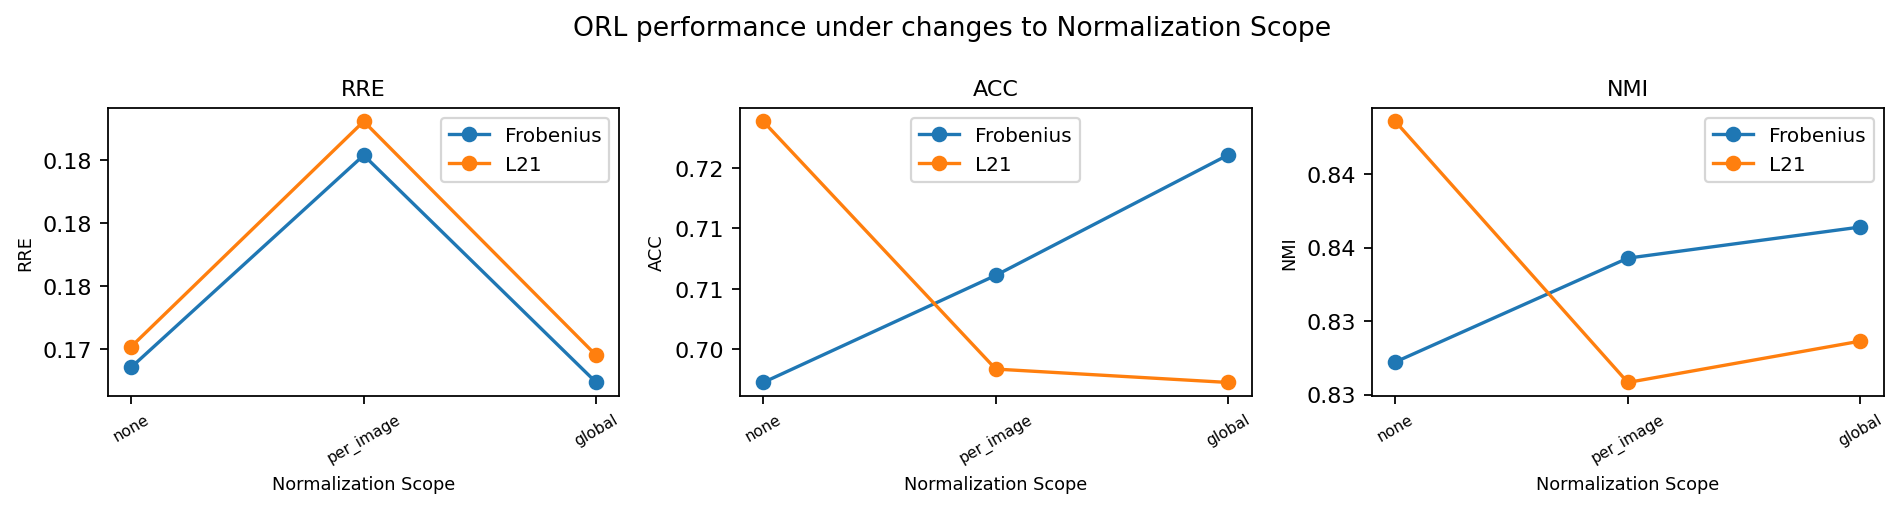

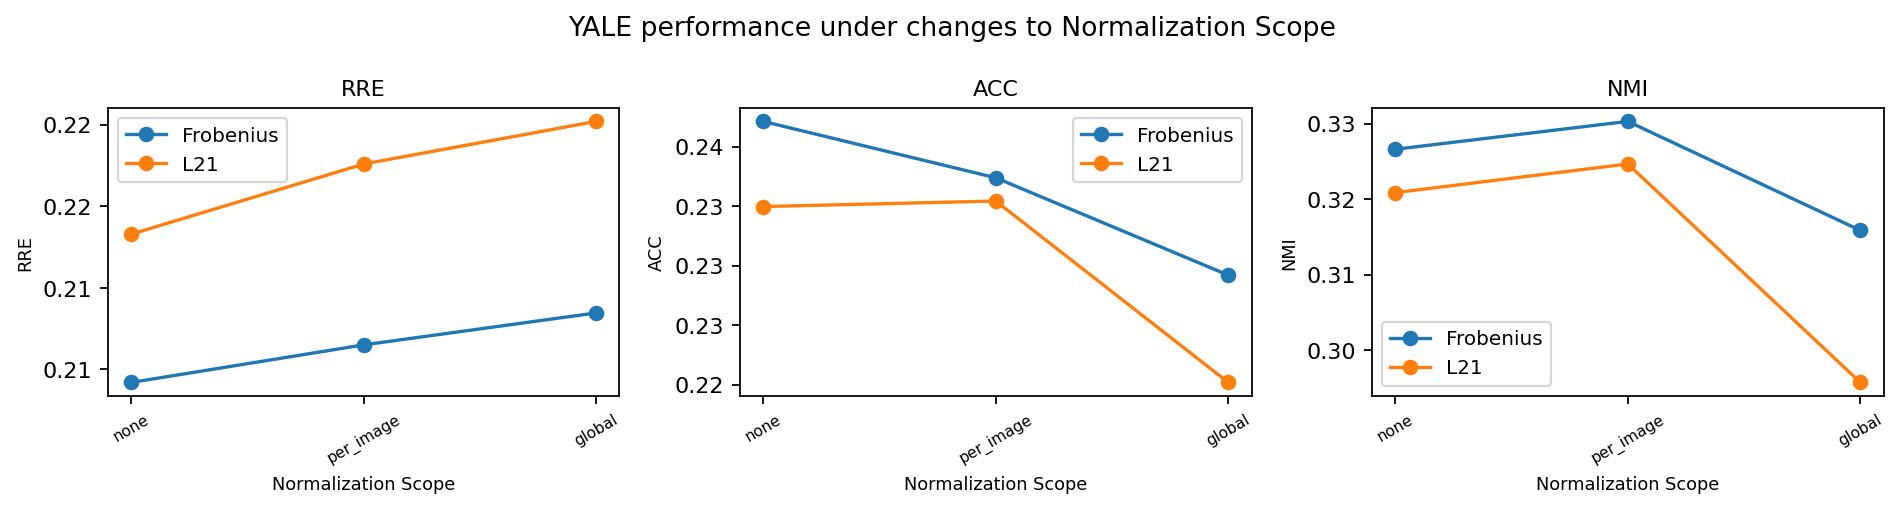

In [370]:
x_label = 'Normalization Scope'
labels = 'normalization'
plot_results(result_norm, x_label, labels, legend_name=None)

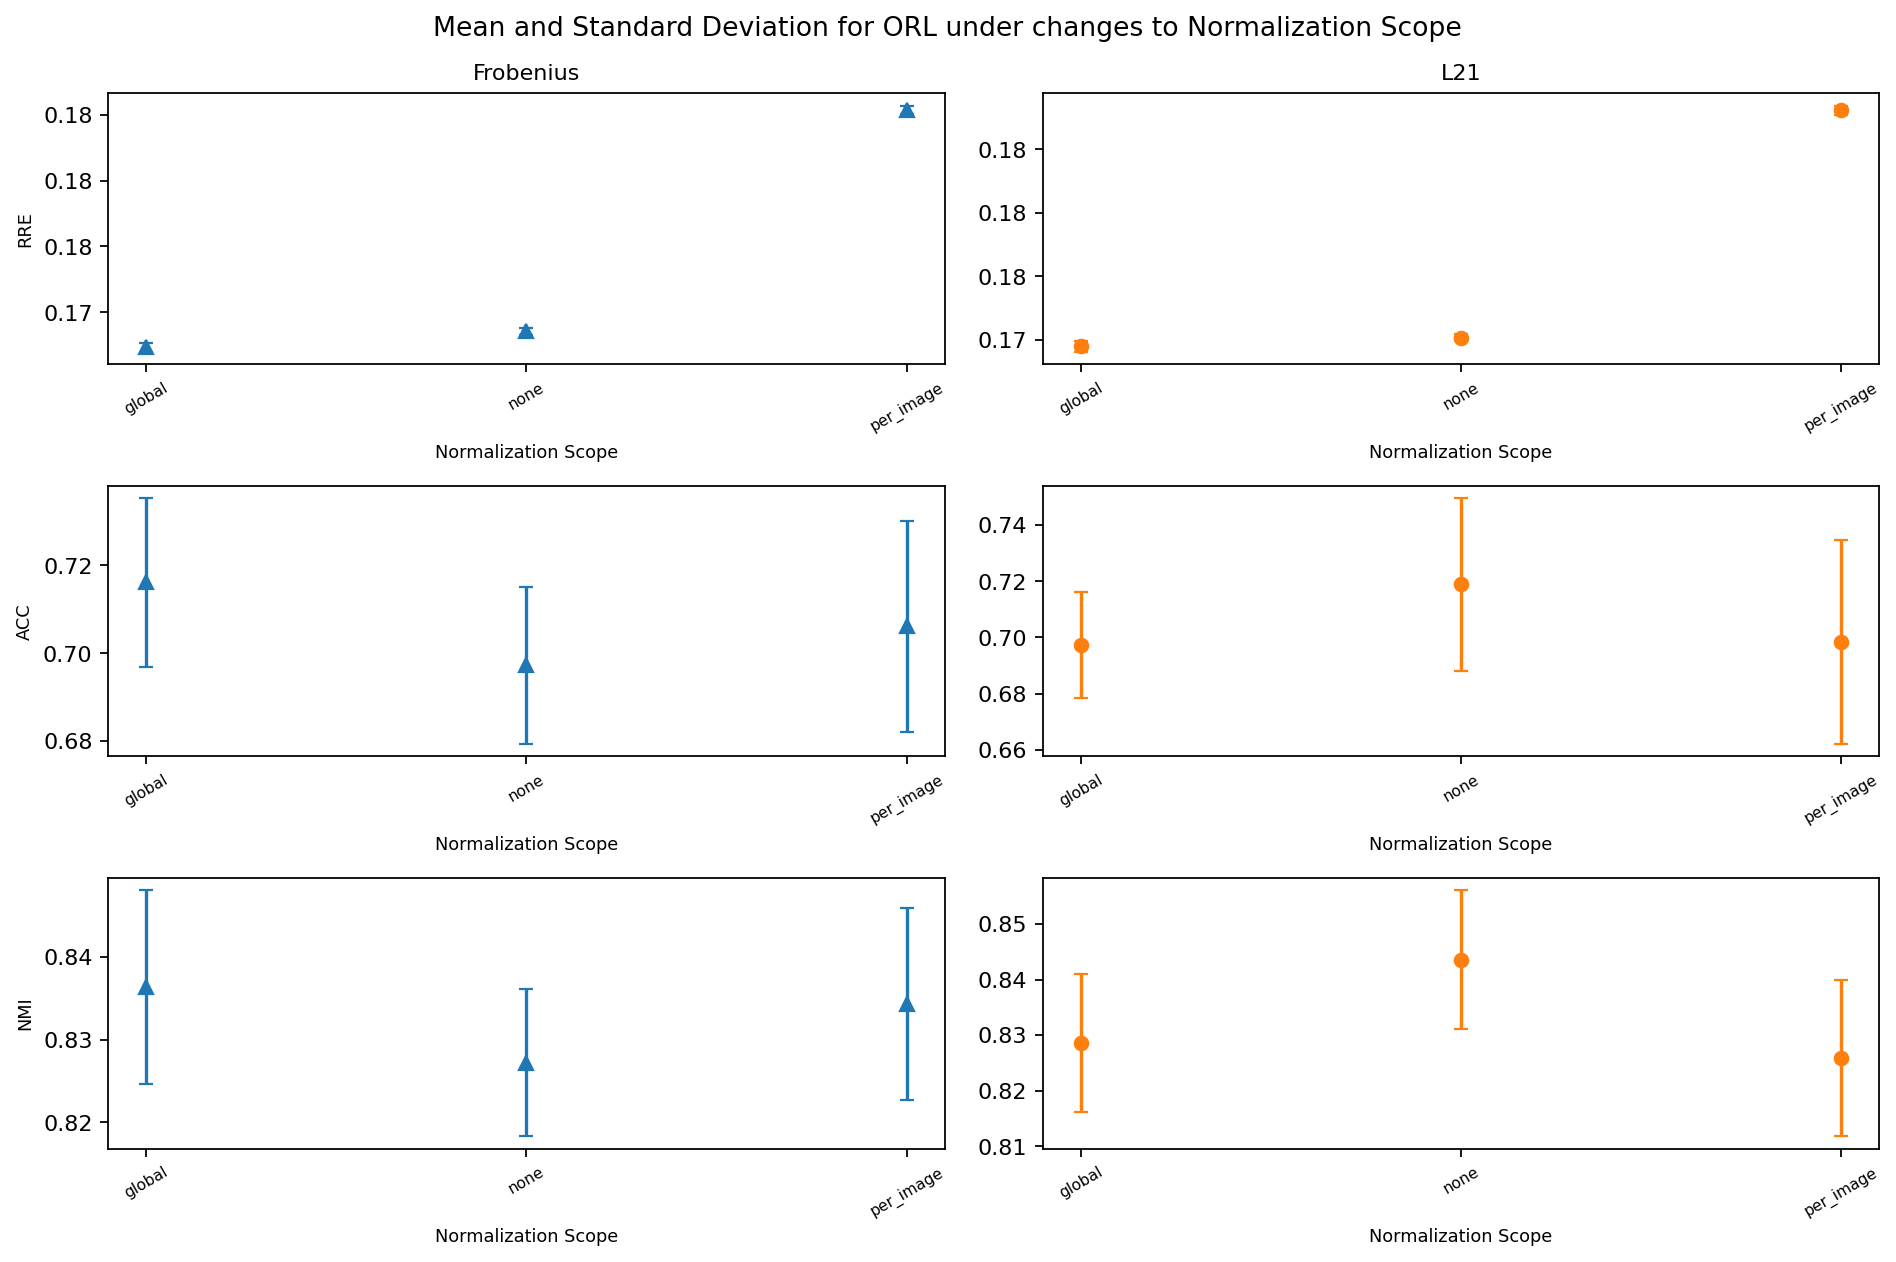

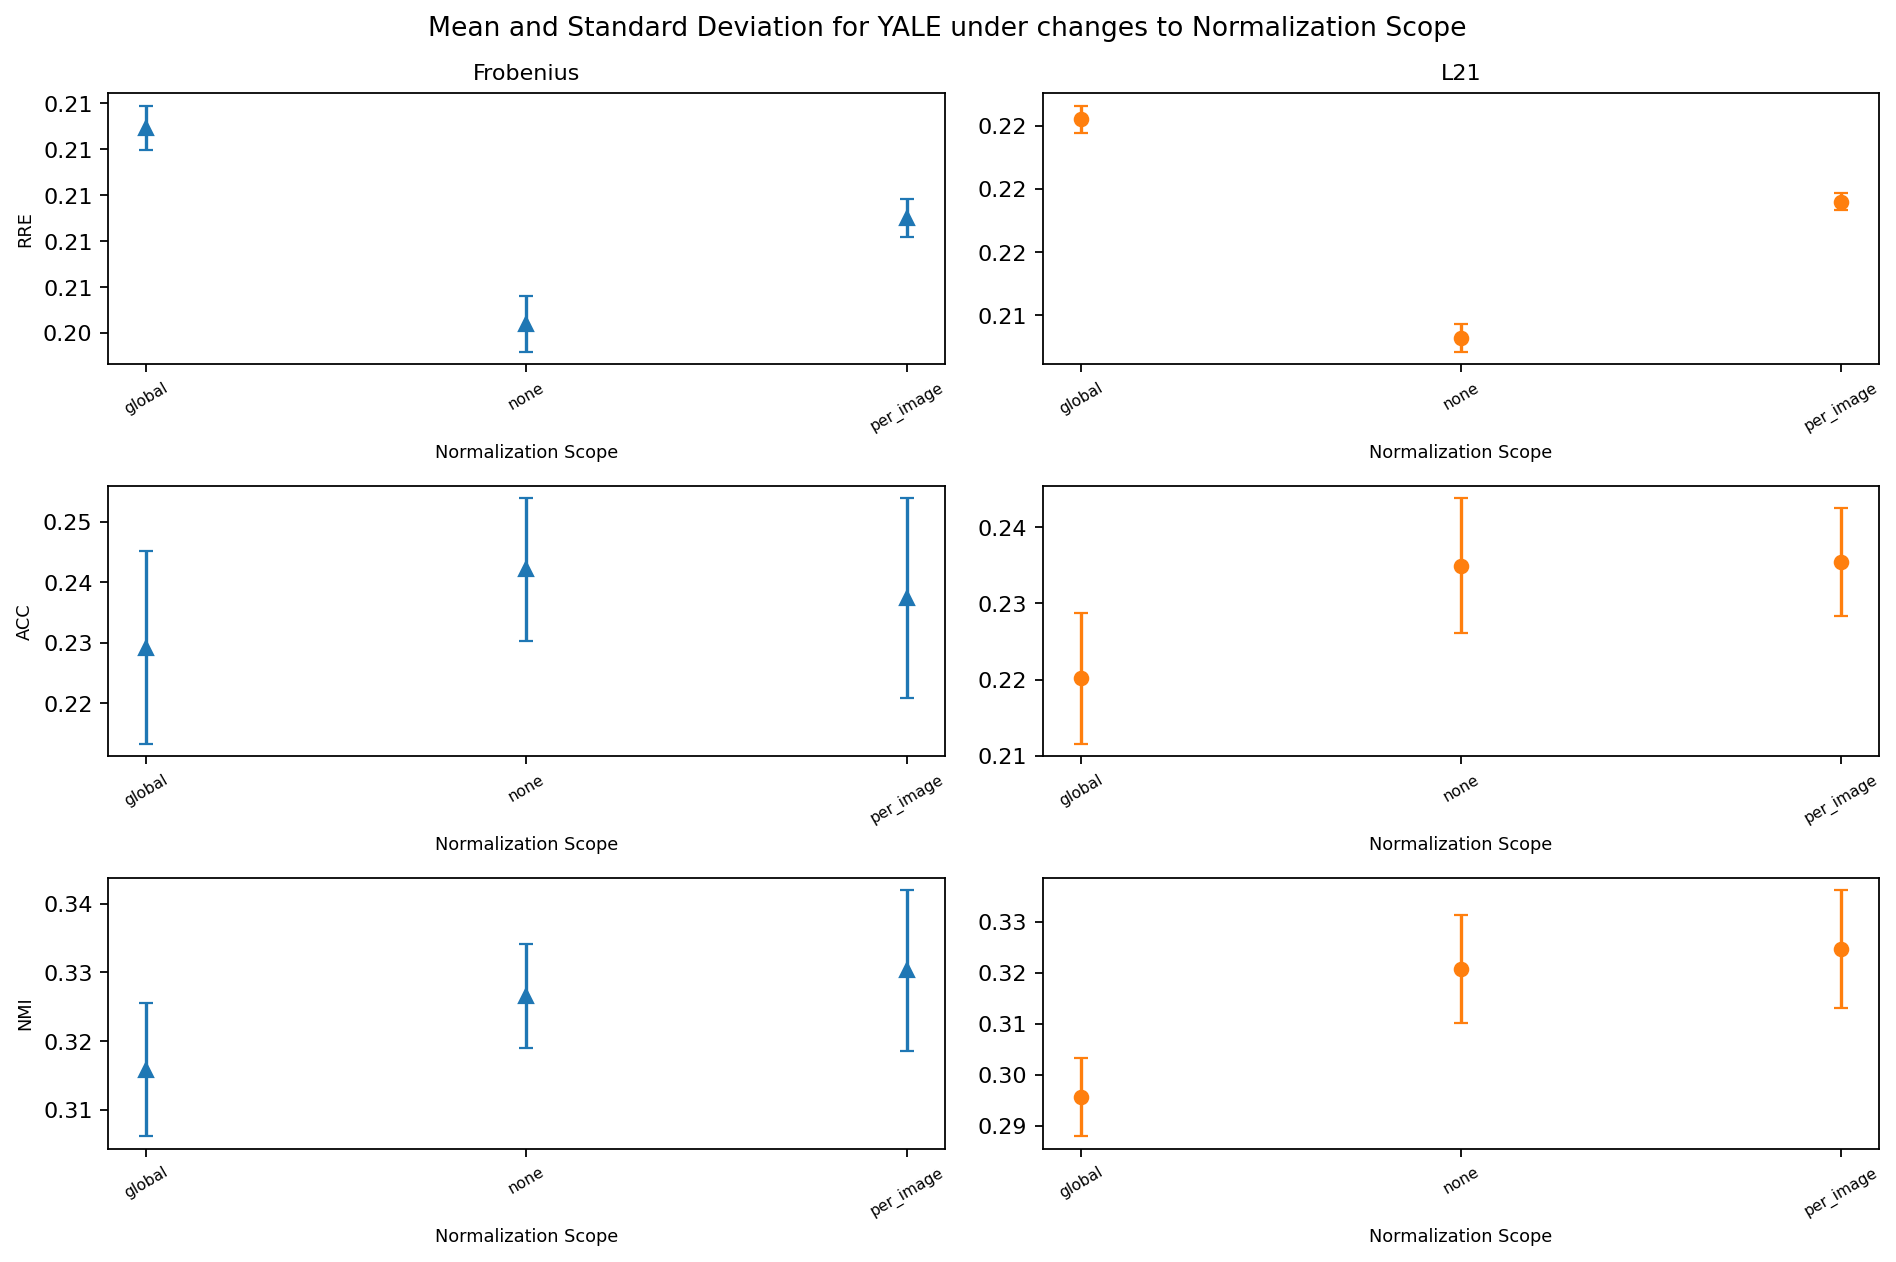

In [371]:
plot_results_deviation(result_norm, x_label, labels)


### 3.2 Experiment about rank

In [372]:
# experiment about rank on ORL and yale
k_grid   = list(range(10, 141, 10))

# create each cfg
configs = []
for ds in datasets:
    for m in methods:
        for k in k_grid:
            cfg = {**base, "dataset": ds, "nmf_type": m, "rank": k}
            configs.append(cfg)

result_rank = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)

Running 56 configs
dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.4s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 70
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 80
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset:

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 20
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 30
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 40
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 60
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.5min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: Frobenius
rank: 140
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 10
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_Y

[Parallel(n_jobs=-1)]: Done  39 out of  56 | elapsed: 11.1min remaining:  4.8min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 90
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 100
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 110
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 120
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.5
nmf_type: L21
rank: 130
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

d

[Parallel(n_jobs=-1)]: Done  45 out of  56 | elapsed: 14.2min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  51 out of  56 | elapsed: 17.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 20.0min finished


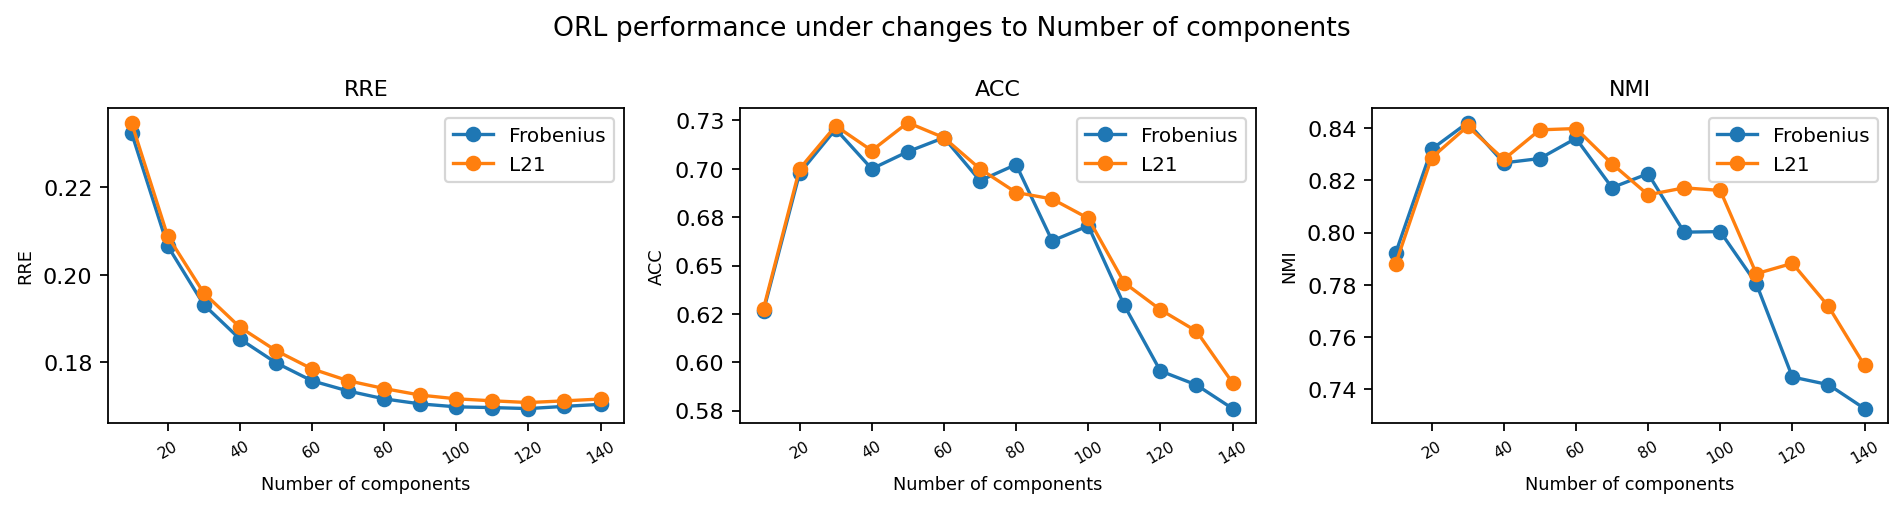

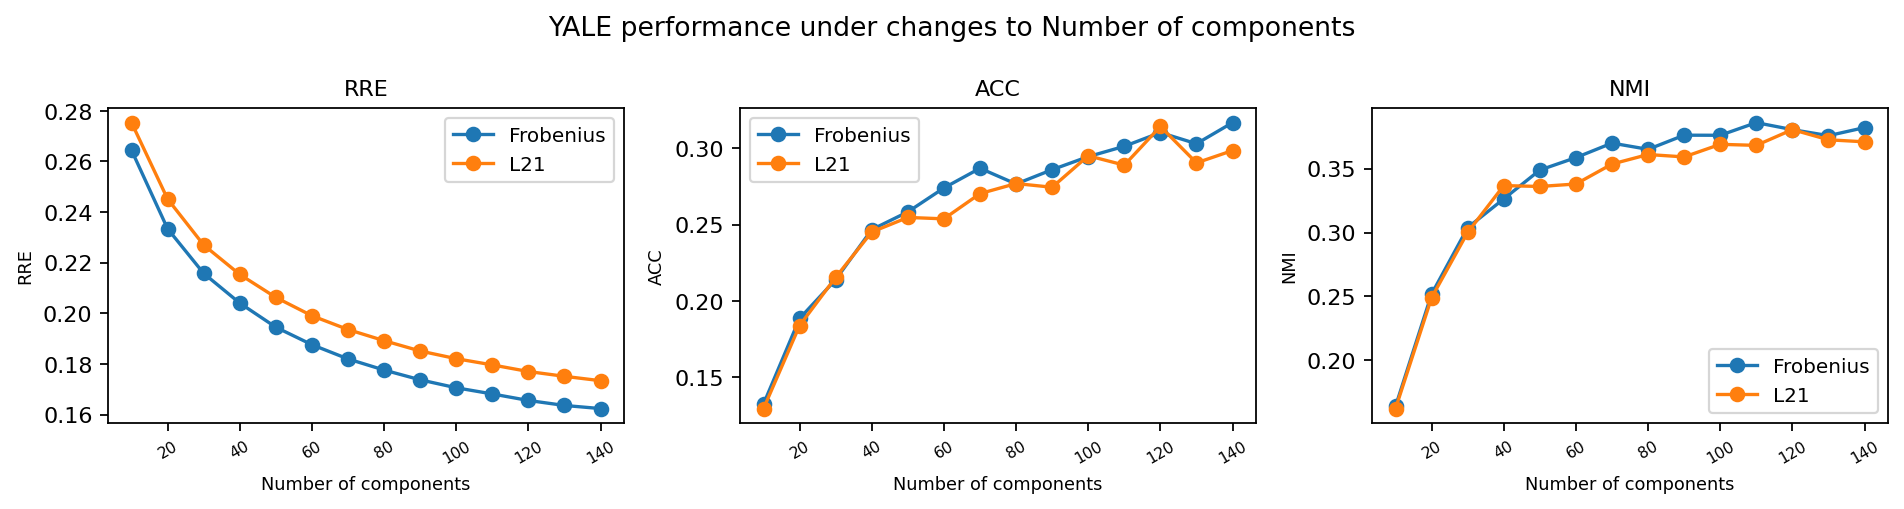

In [373]:
# Plot the results of experimenting about rank
x_label = 'Number of components'
labels = 'k'
plot_results(result_rank, x_label, labels, legend_name=None)


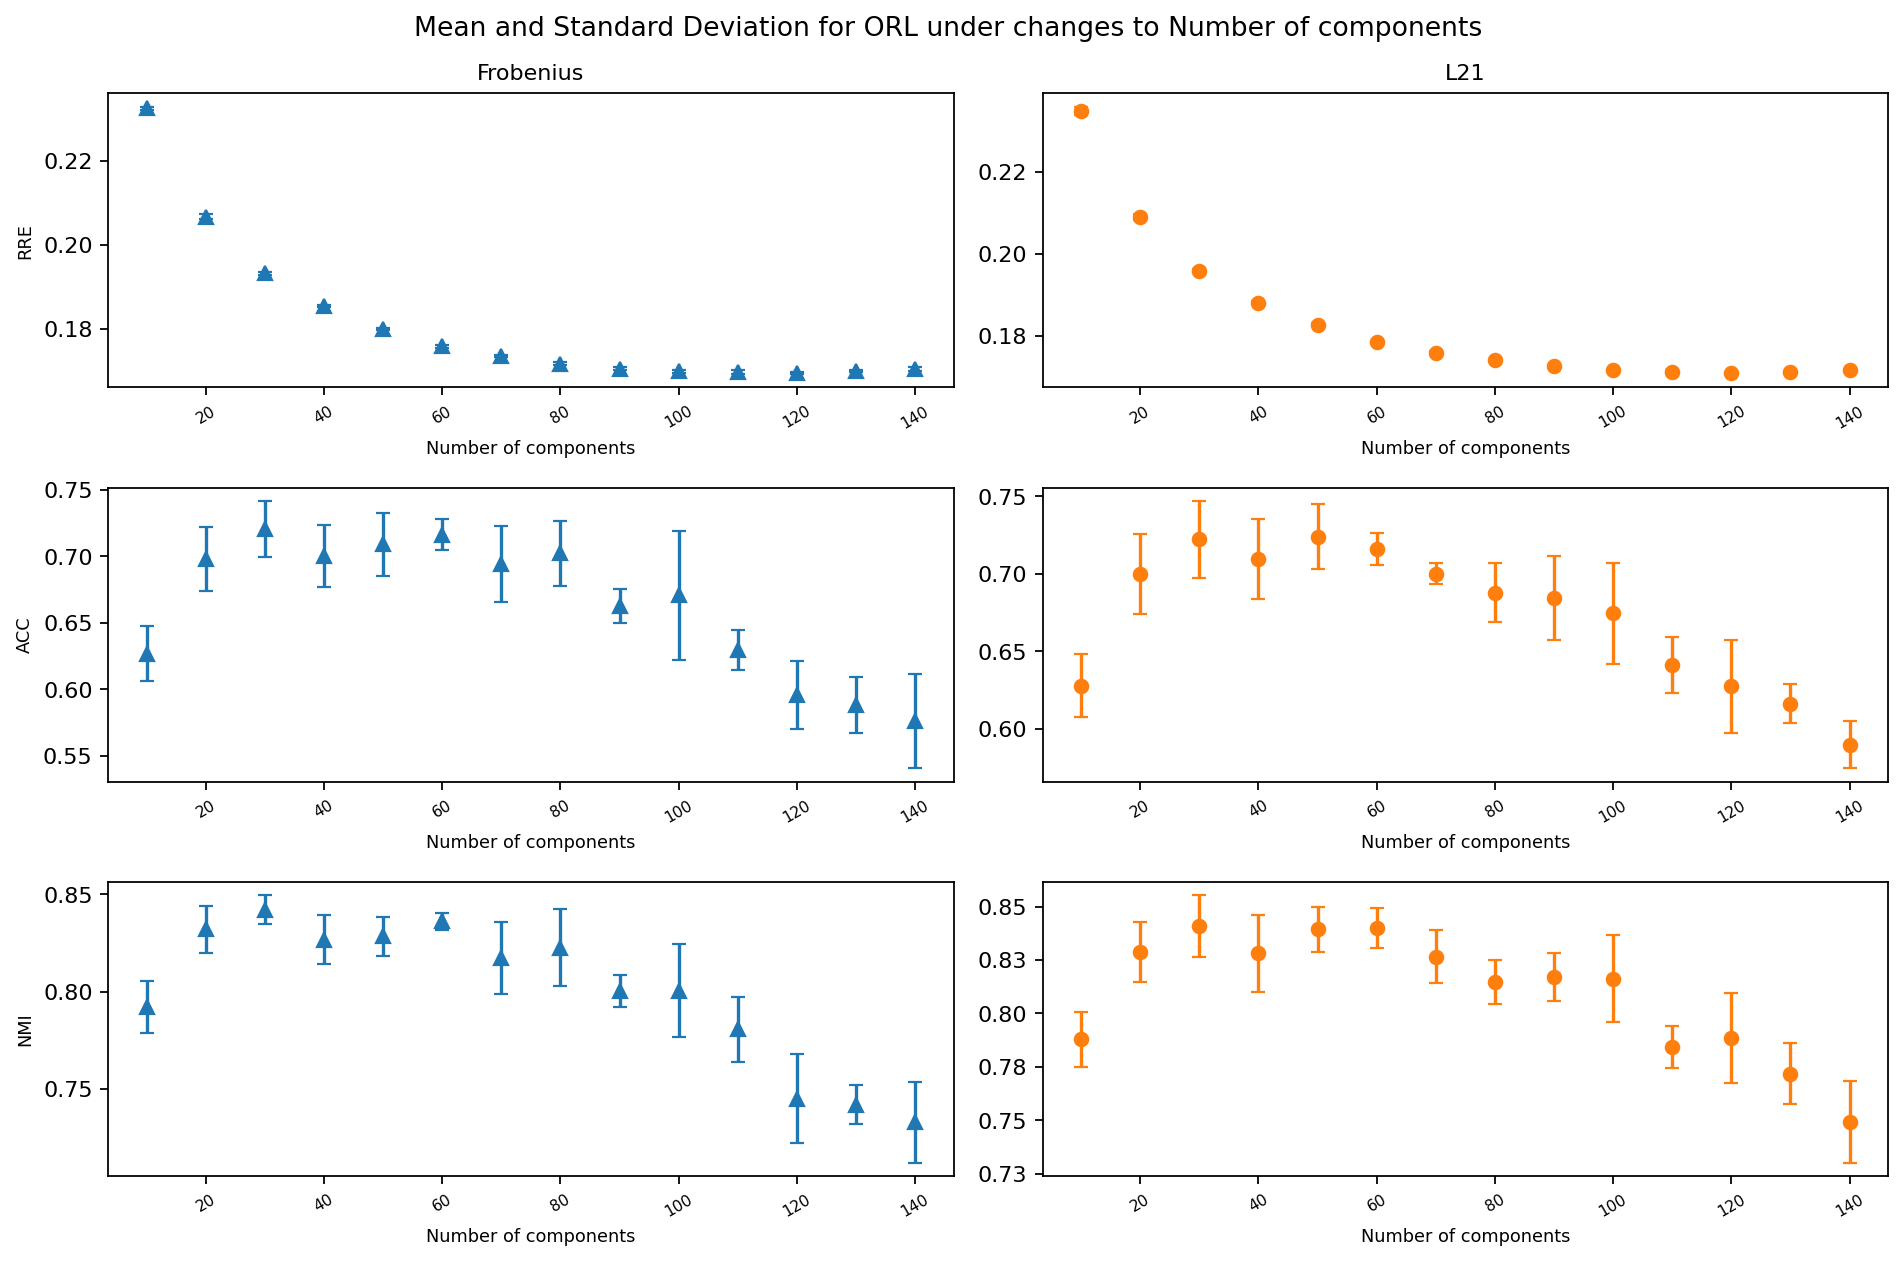

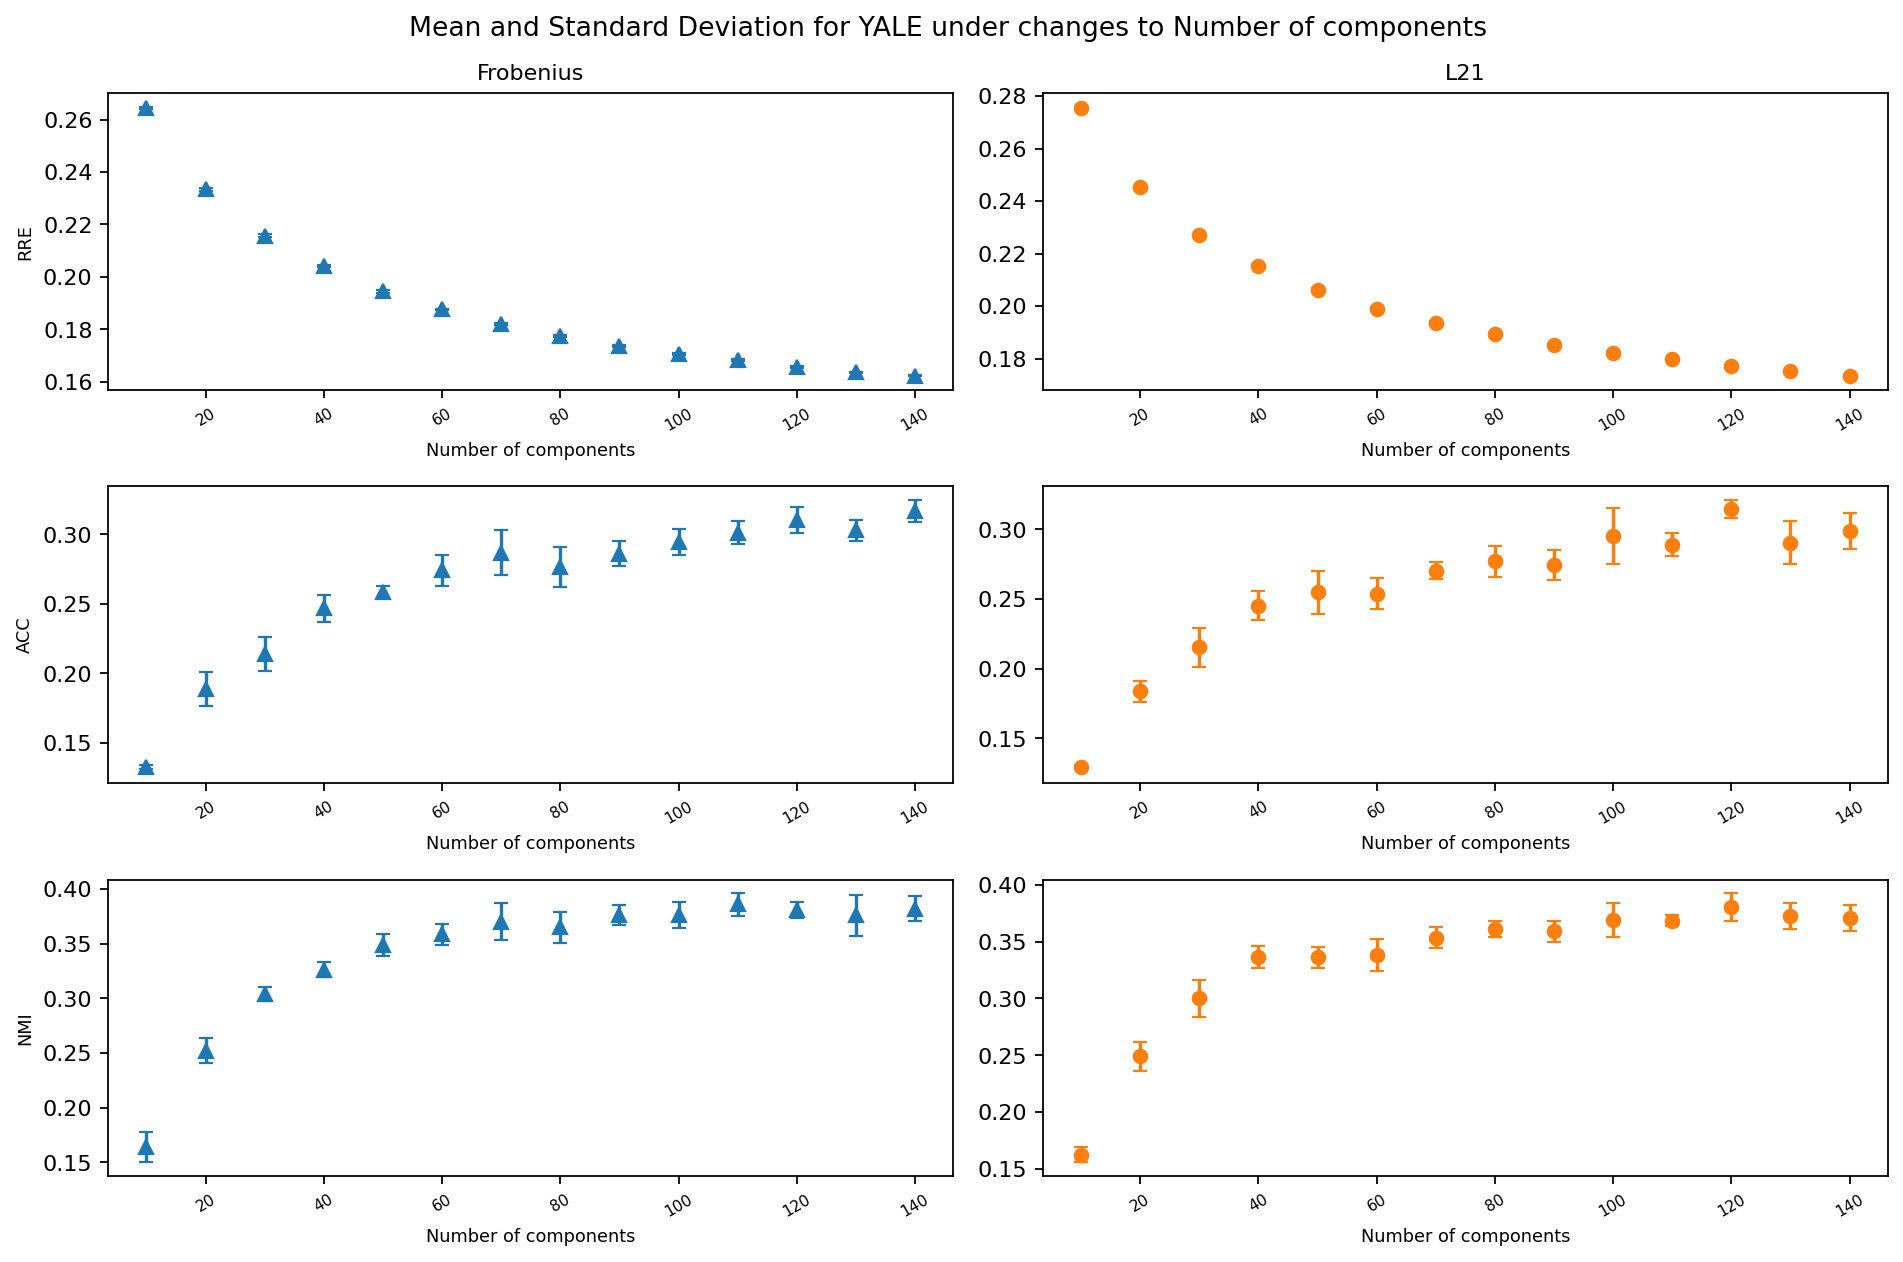

In [374]:
plot_results_deviation(result_rank, x_label, labels)

### 3.3 Robustness to noise

In [375]:
# Generates multiple configs that test all combinations of settings values
configs = []
for ds in datasets:
    for m in methods:
        for p, r in sp_noise_combos:
            cfg = {
                **base,
                "dataset": ds,
                "nmf_type": m,
                "rank": 50,
                "noise_p": p,
                "noise_r": r,
                "noise_type": "salt_pepper"
            }
            configs.append(cfg)

result_salt = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)

df = pd.DataFrame(result_salt)
log_experiment(df, 'Salt & Pepper Noise')

Running 28 configs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.7s


dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.3
noise_r: 0.3
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: ORL
normalization: per_image
noise_type: salt_pepper
noise_p: 0.3
noise_r: 0.7
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon:

[Parallel(n_jobs=-1)]: Done   8 out of  28 | elapsed:   54.3s remaining:  2.3min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.3
noise_r: 0.7
nmf_type: Frobenius
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.01
noise_r: 0.5
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12



[Parallel(n_jobs=-1)]: Done  11 out of  28 | elapsed:  1.0min remaining:  1.6min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.05
noise_r: 0.3
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.5
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.1
noise_r: 0.7
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12



[Parallel(n_jobs=-1)]: Done  14 out of  28 | elapsed:  1.1min remaining:  1.1min


dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.2
noise_r: 0.5
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.3
noise_r: 0.3
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

dataset: YALE
normalization: per_image
noise_type: salt_pepper
noise_p: 0.3
noise_r: 0.7
nmf_type: L21
rank: 50
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12



[Parallel(n_jobs=-1)]: Done  17 out of  28 | elapsed:  4.6min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  20 out of  28 | elapsed:  5.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  23 out of  28 | elapsed:  5.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  26 out of  28 | elapsed:  6.9min remaining:   31.9s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  7.5min finished


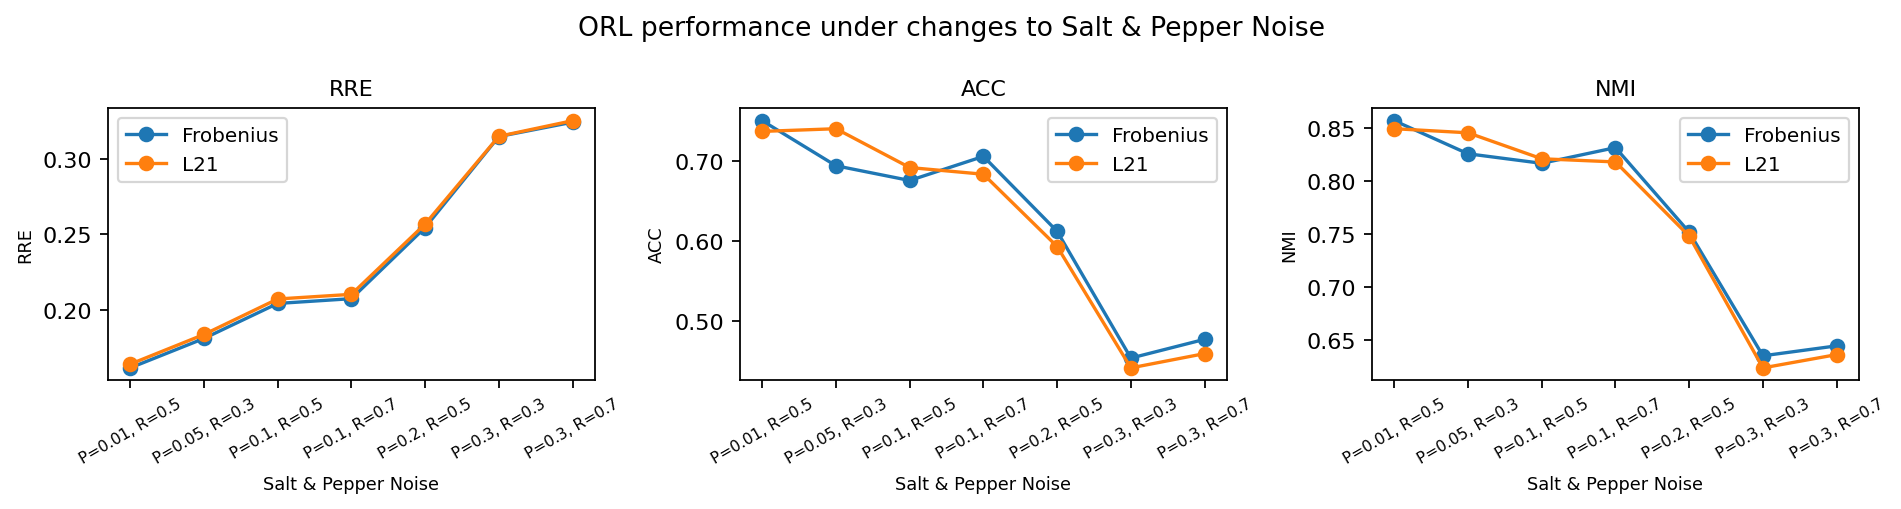

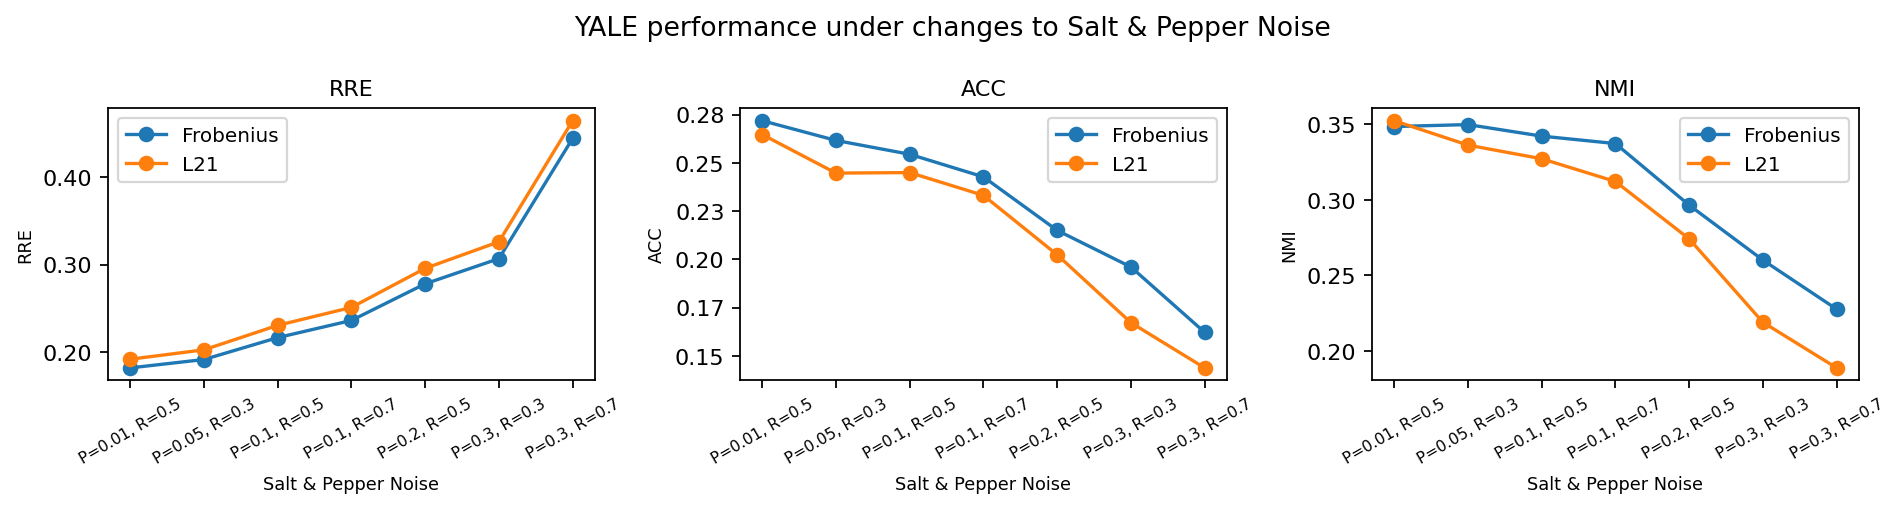

In [376]:
label_names = {'P':'noise_p', 'R':'noise_r'}
x_label = 'Salt & Pepper Noise'
plot_results(result_salt, x_label, label_names)

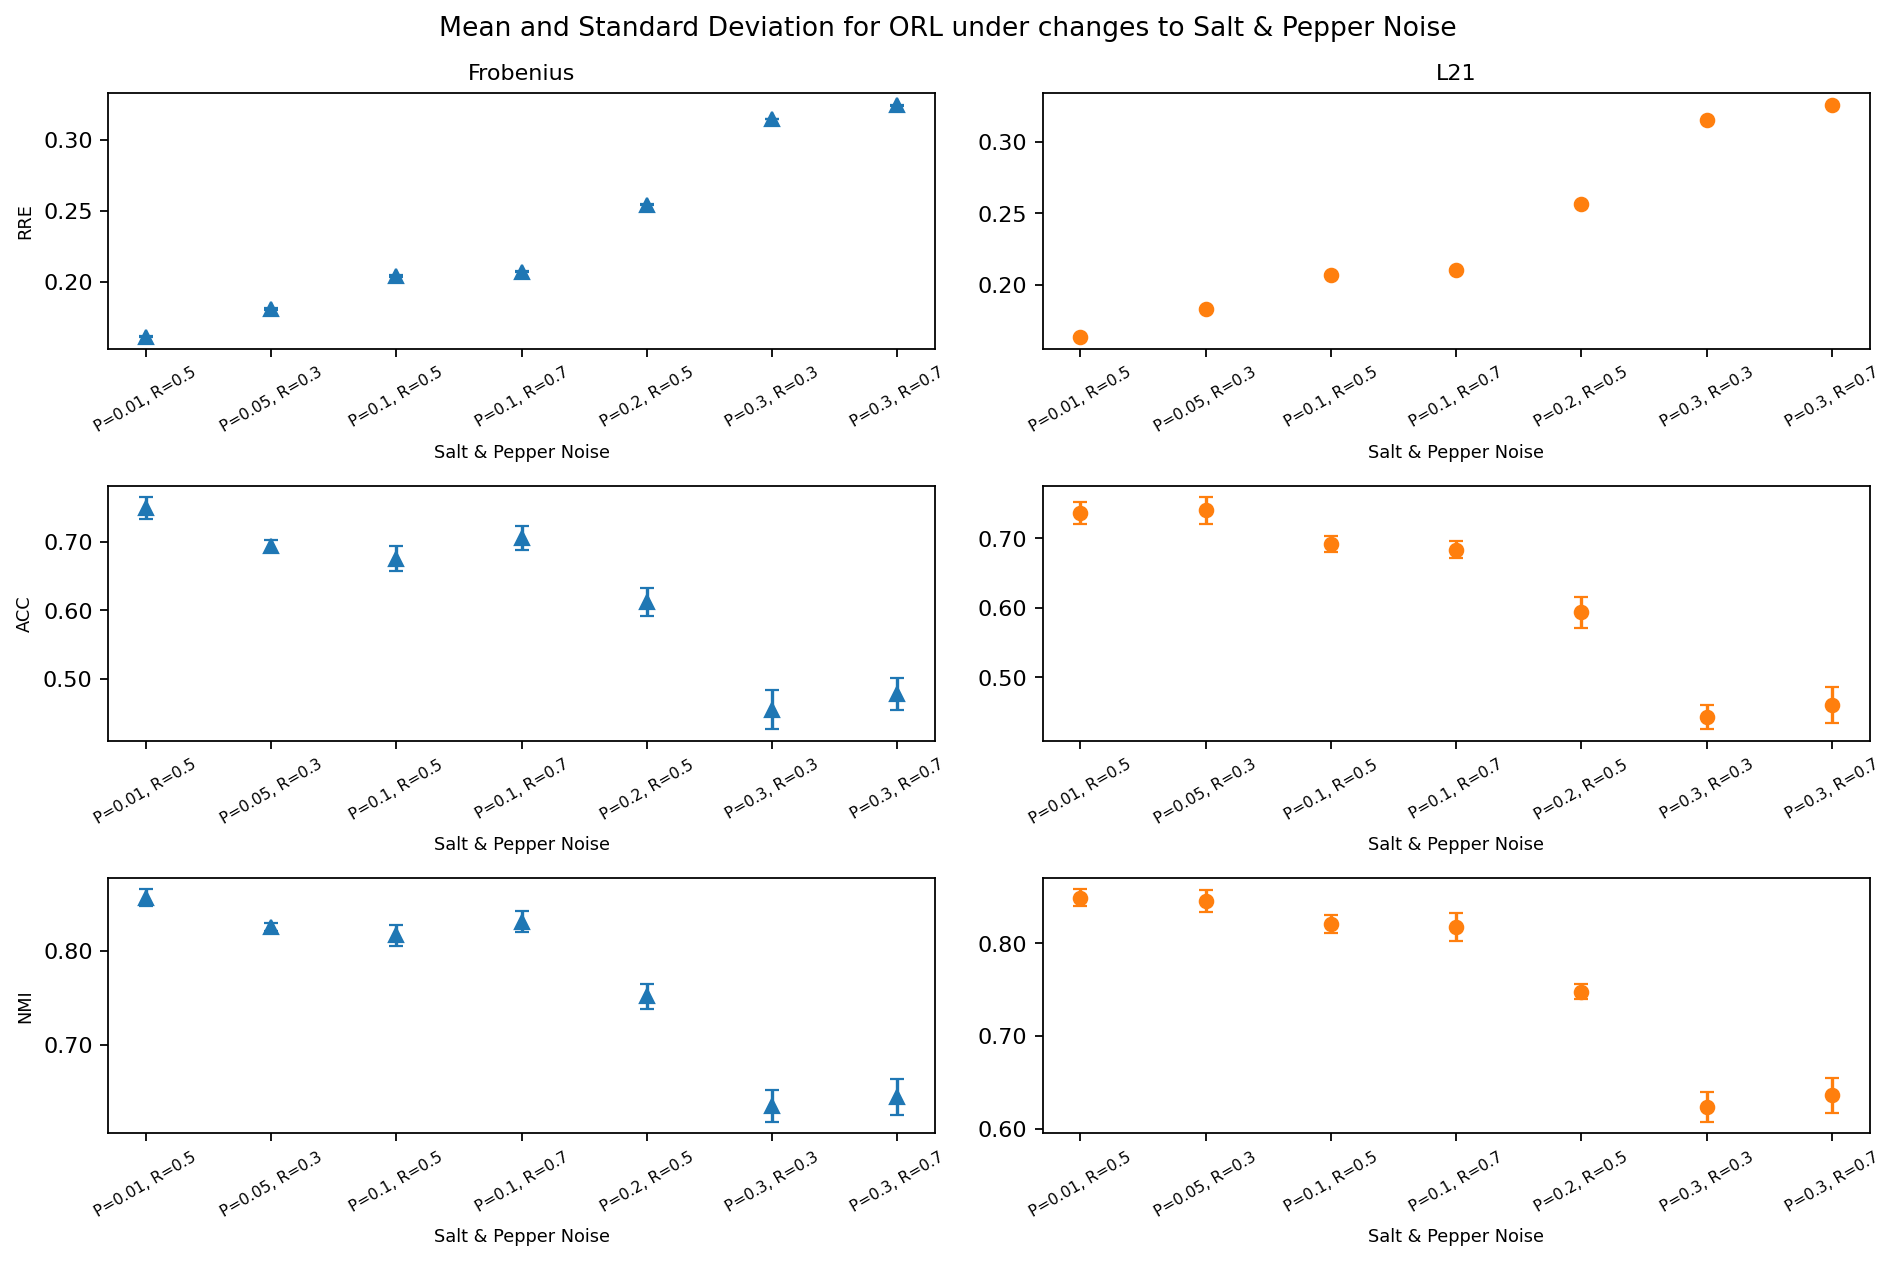

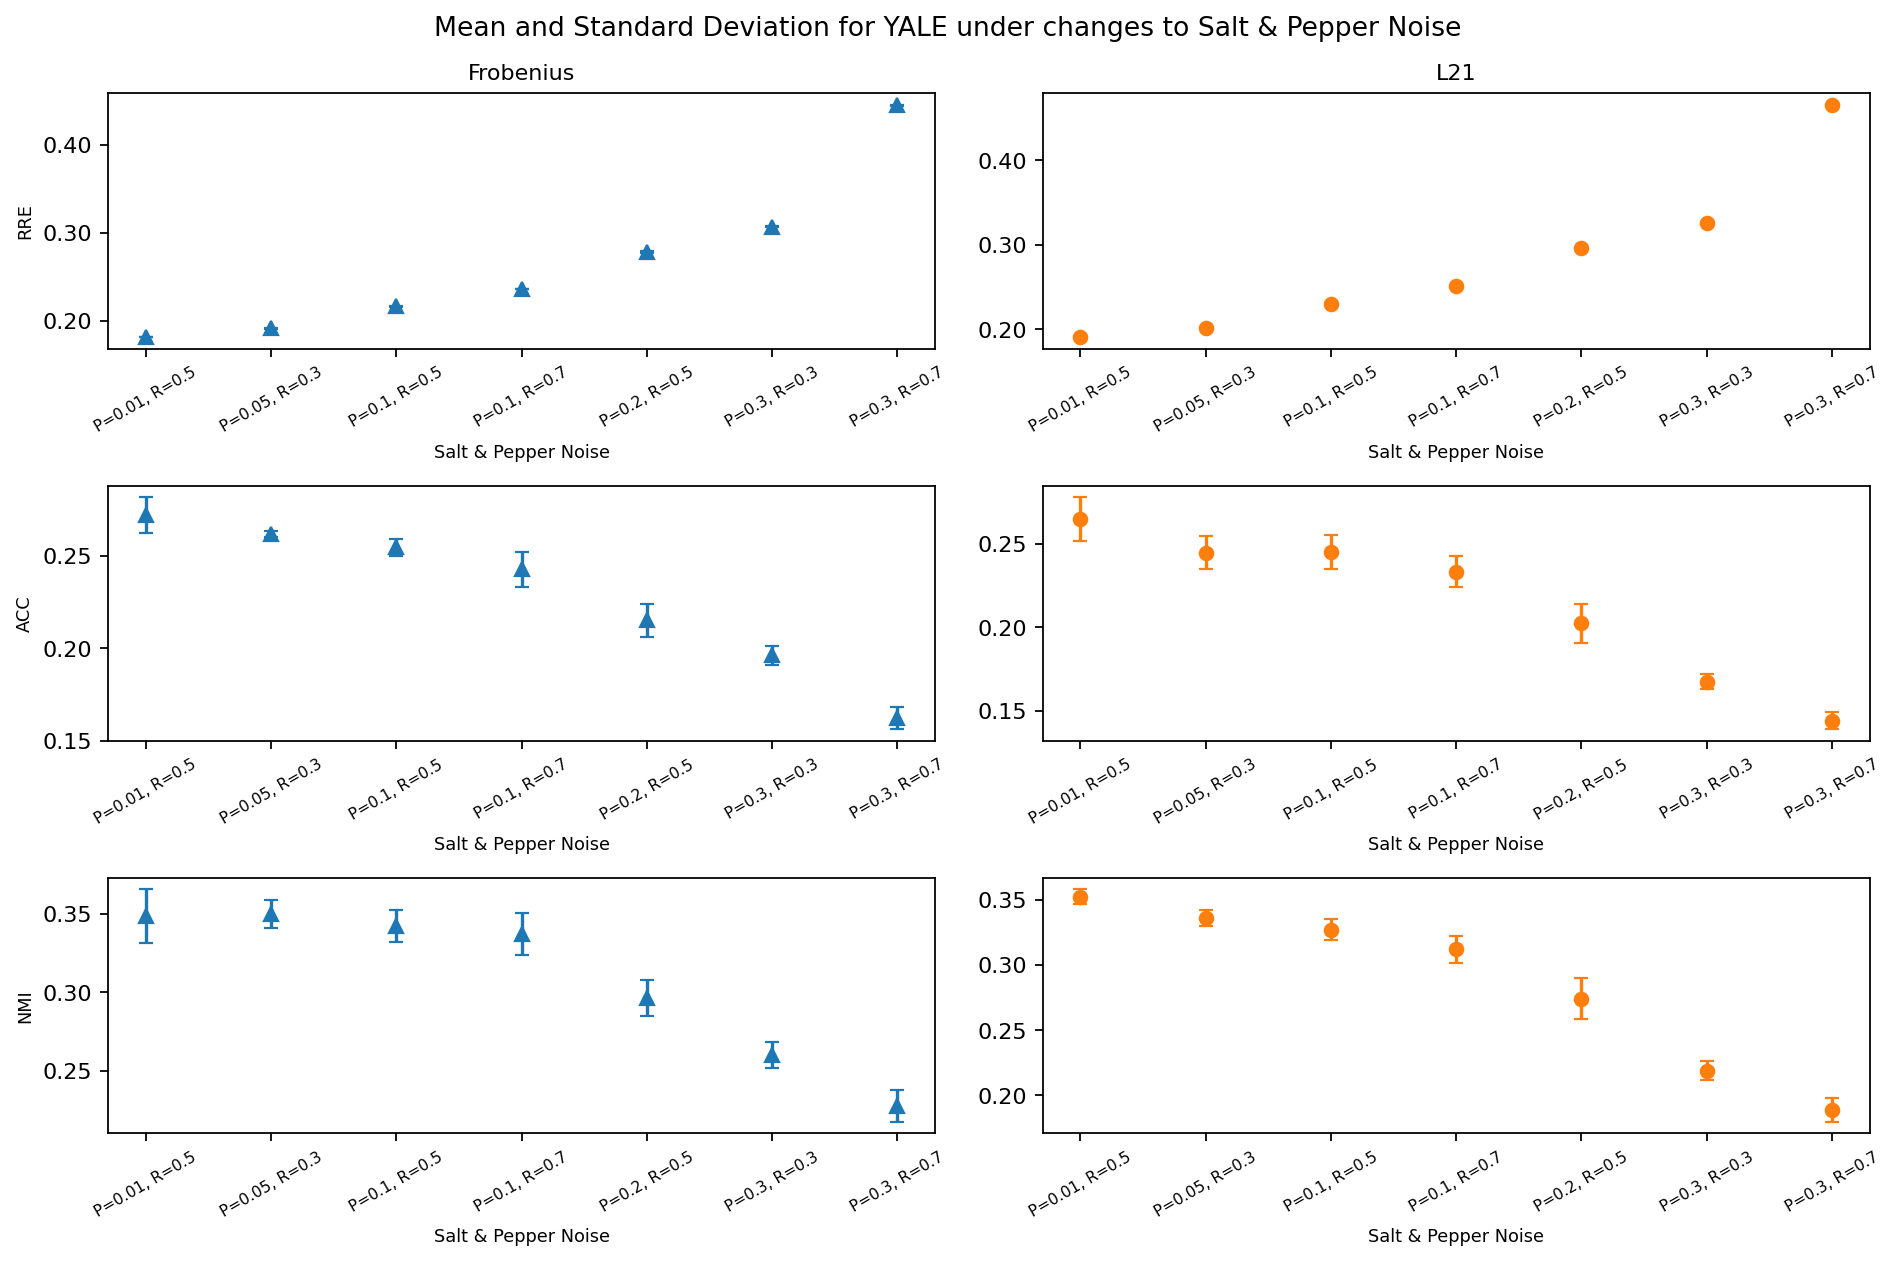

In [377]:
plot_results_deviation(result_salt, x_label, label_names)

In [378]:
# Generates multiple configs that test all combinations of settings values
configs = []
for ds in datasets:
    for m in methods:
        for r in block_noise_ratio:
            for n in num_blocks:
                cfg = {**base, "dataset": ds, "nmf_type": m, "block_ratio": r, "num_blocks": n}
                cfg["noise_type"]= 'block'
                cfg.pop('noise_r')
                cfg.pop('noise_p')
                configs.append(cfg)

In [379]:
# Runs all generated configs
result_block = run_configs_parallel(configs, n_jobs=-1, backend="loky", verbose=10)
df = pd.DataFrame(result_block)

log_experiment(df, 'Block Noise')

Running 48 configs
dataset: ORL
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 1

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 2

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 3

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 1

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 1



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   59.4s


dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 2

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.1
num_blocks: 3

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 1

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 2

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 3

dataset: O

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min


dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 2

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 3

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 1

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 2

dataset: ORL
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 3

dataset: Y

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min


dataset: YALE
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 2

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 3

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 1

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 2

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: Frobenius
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_r

[Parallel(n_jobs=-1)]: Done  30 out of  48 | elapsed:  9.0min remaining:  5.4min


dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.2
num_blocks: 3

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 1

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 2

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.3
num_blocks: 3

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 1



[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed:  9.4min remaining:  3.5min


dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 2

dataset: YALE
normalization: per_image
noise_type: block
nmf_type: L21
rank: auto
max_iterations: 1000
tol: 0.0001
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12
block_ratio: 0.4
num_blocks: 3



[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed: 16.0min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  45 out of  48 | elapsed: 16.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 16.5min finished


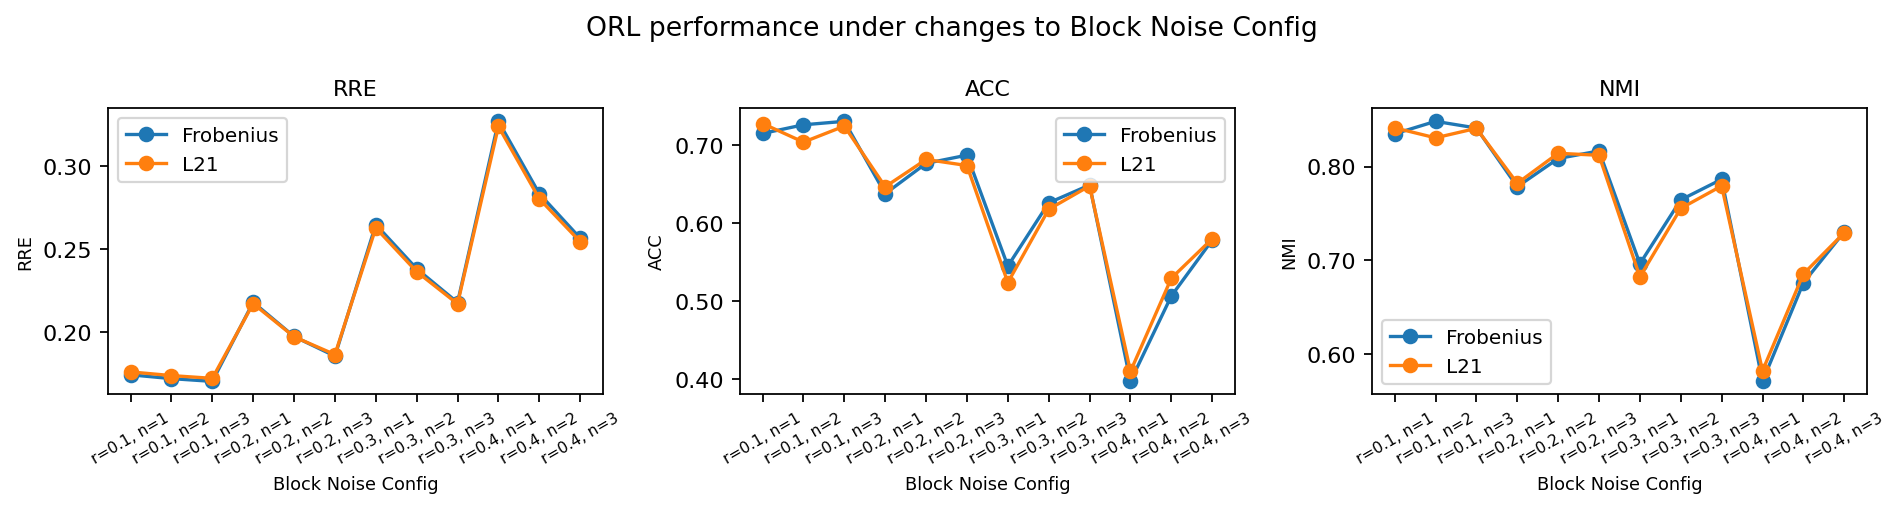

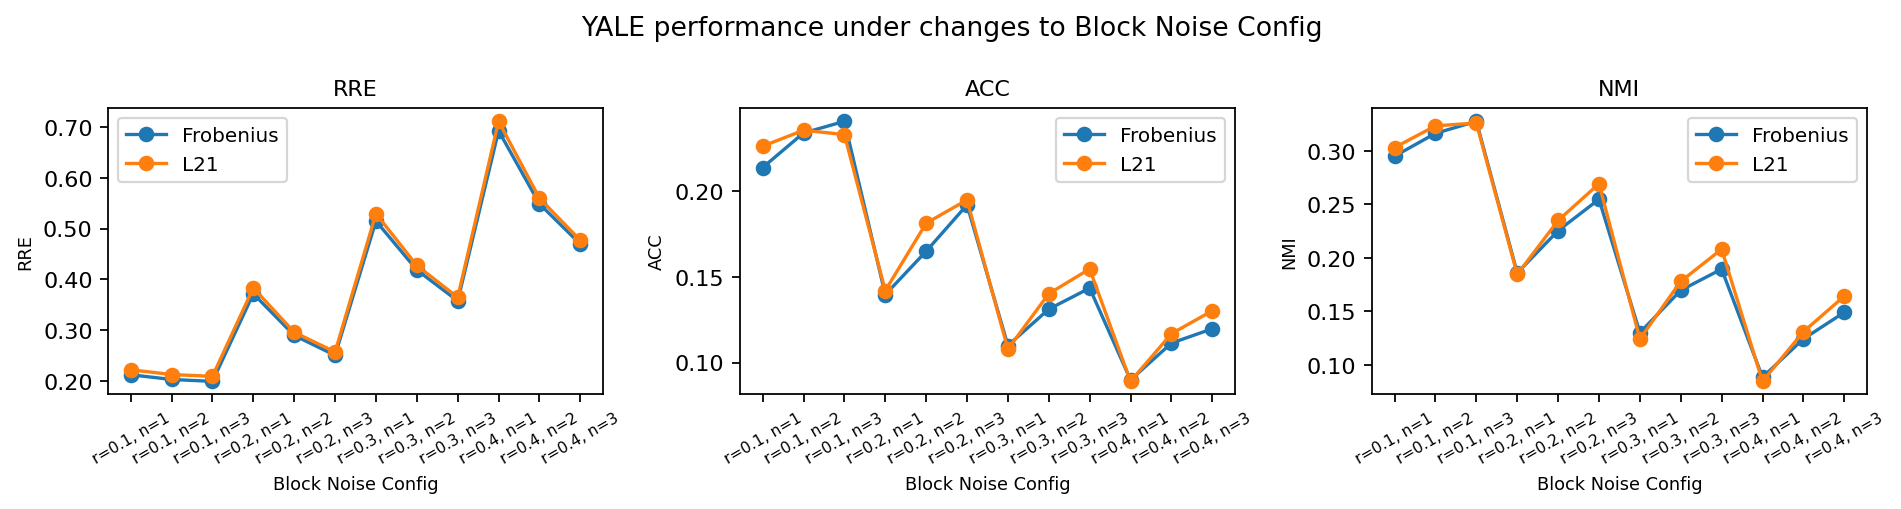

In [380]:
# Plot the results of noise configuration experimentation
x_label = 'Block Noise Config'
labels = { 'r':'block_ratio', 'n':'num_blocks'}
plot_results(result_block, x_label, labels, legend_name=None)

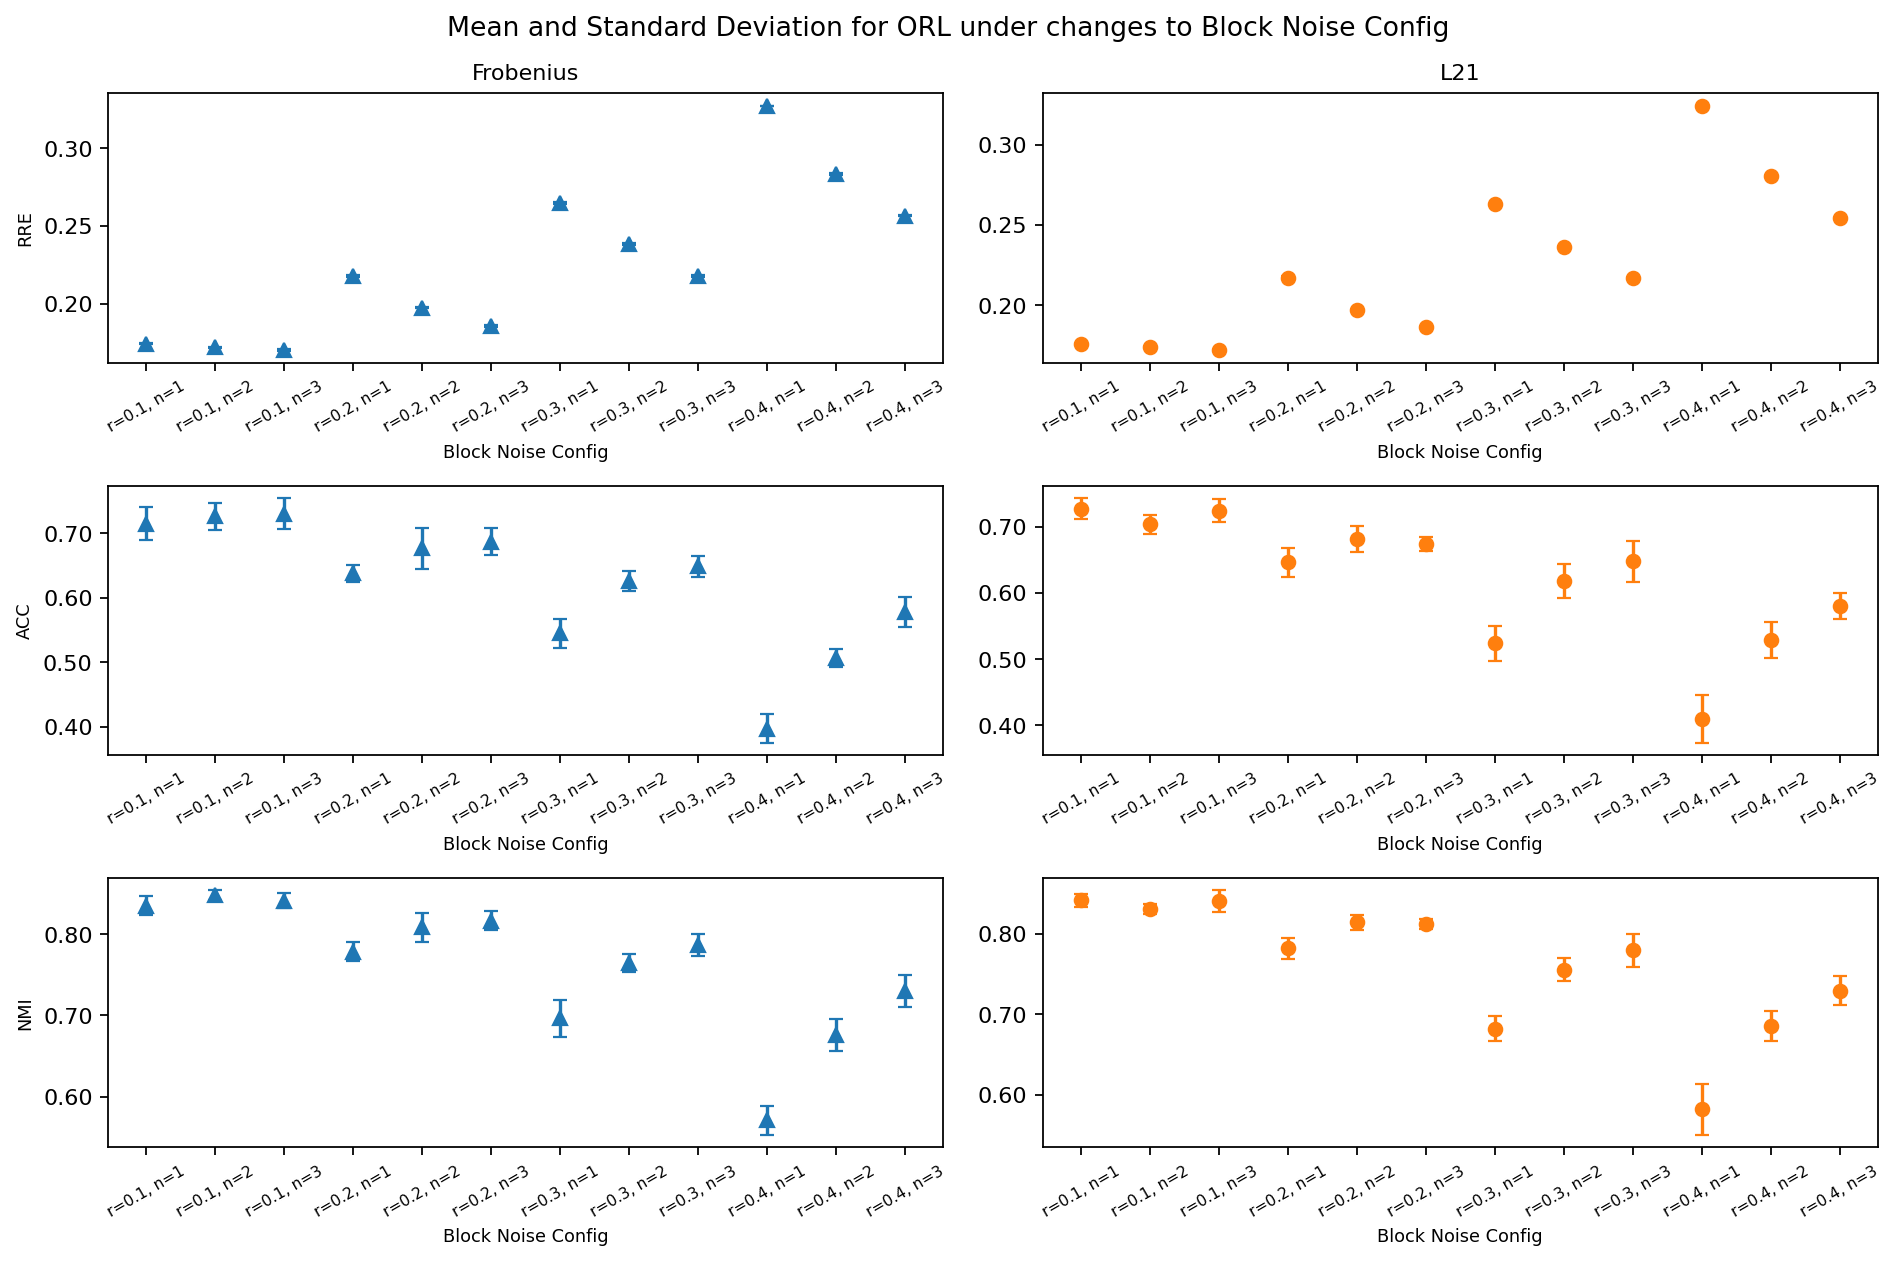

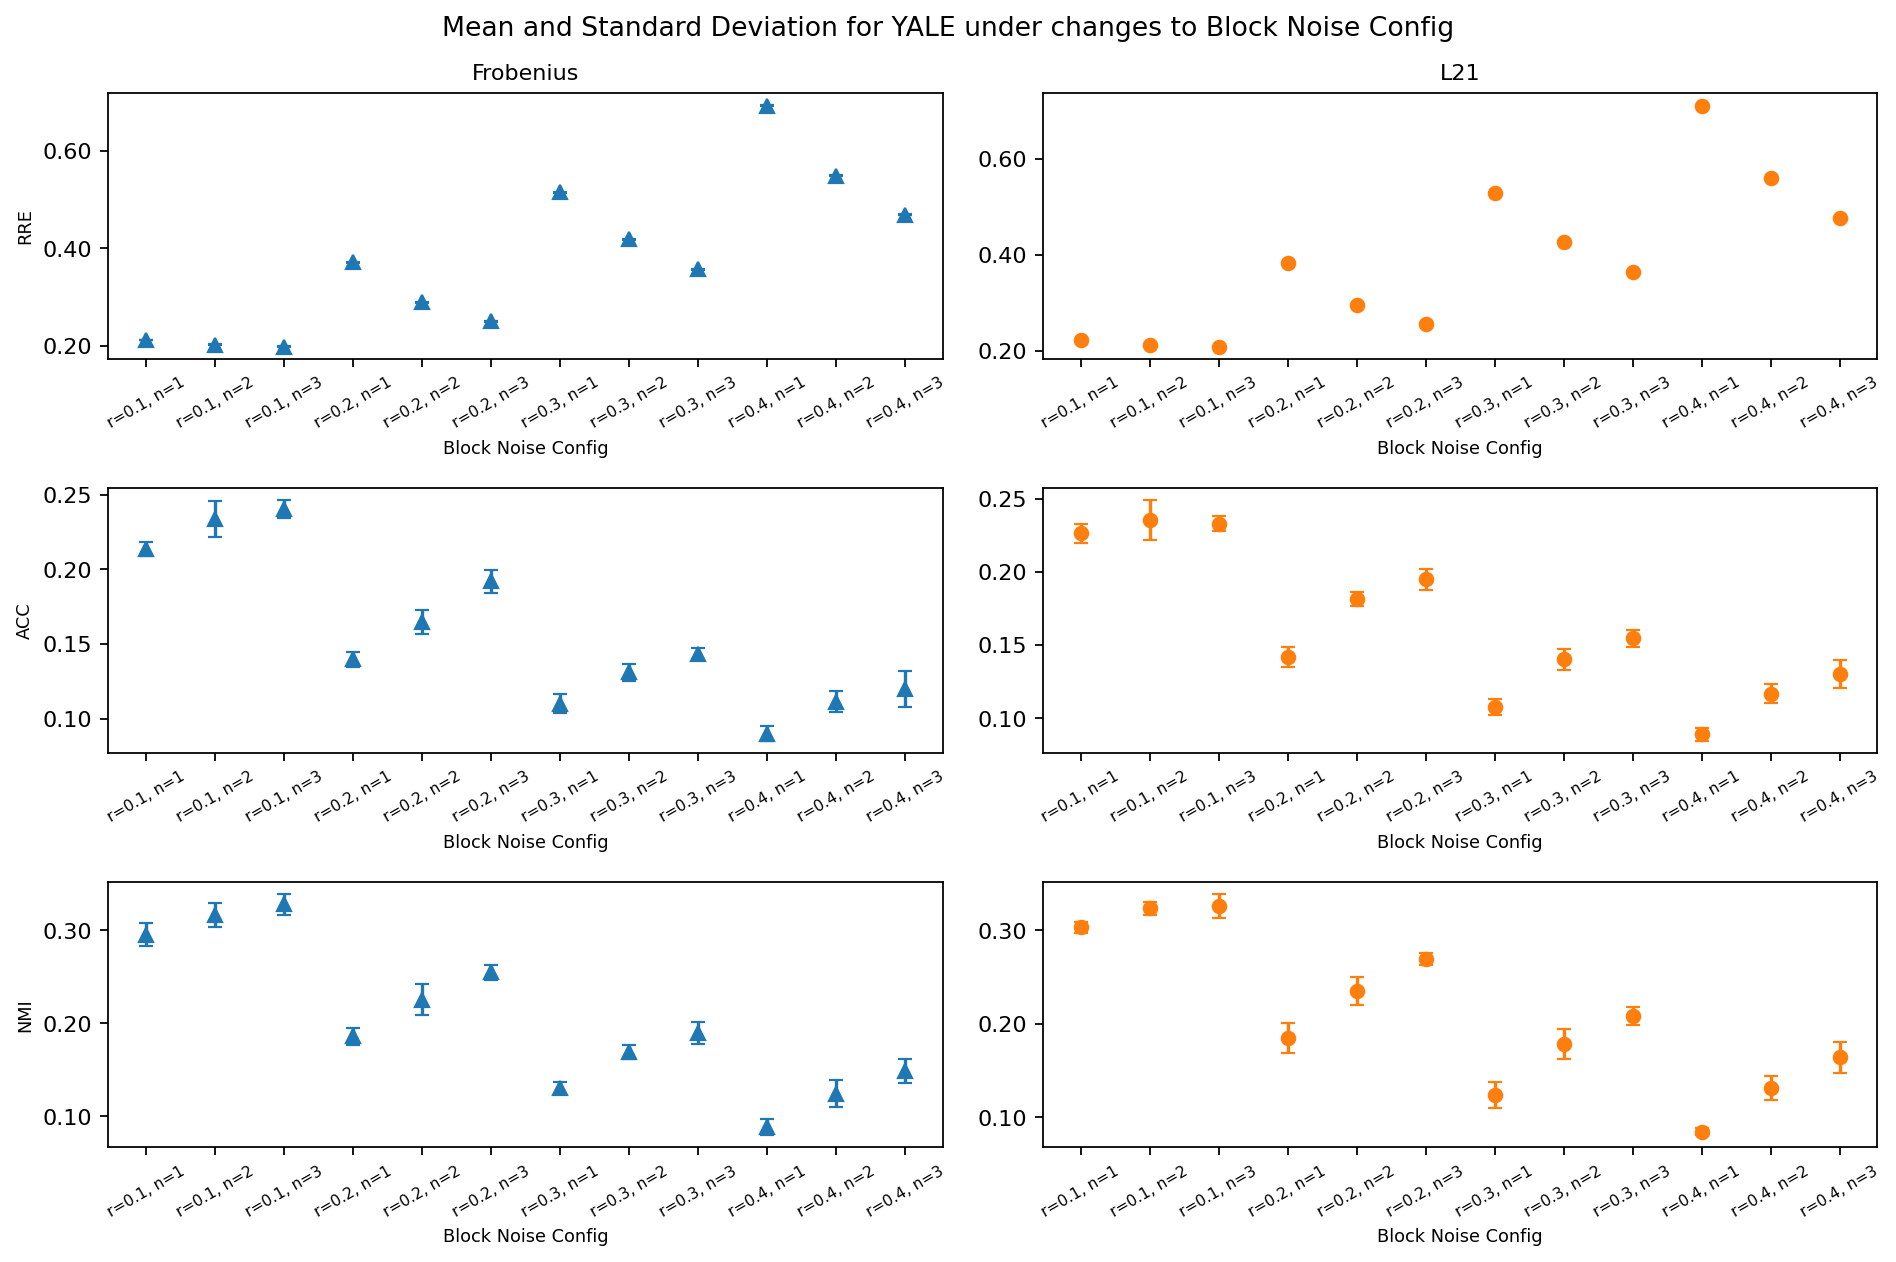

In [381]:
plot_results_deviation(result_block, x_label, labels)